# Implementation DCGAN and cDCGAN

In [1]:
import tensorflow as tf 
from tensorflow.python.client import device_lib
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15351831182912710347
xla_global_id: -1
]


# Import the dataset (Fashion MNIST)

In [2]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [3]:
print('Labels of the dataset', set(trainy))

Labels of the dataset {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


# Vizualize the data

<IPython.core.display.Javascript object>


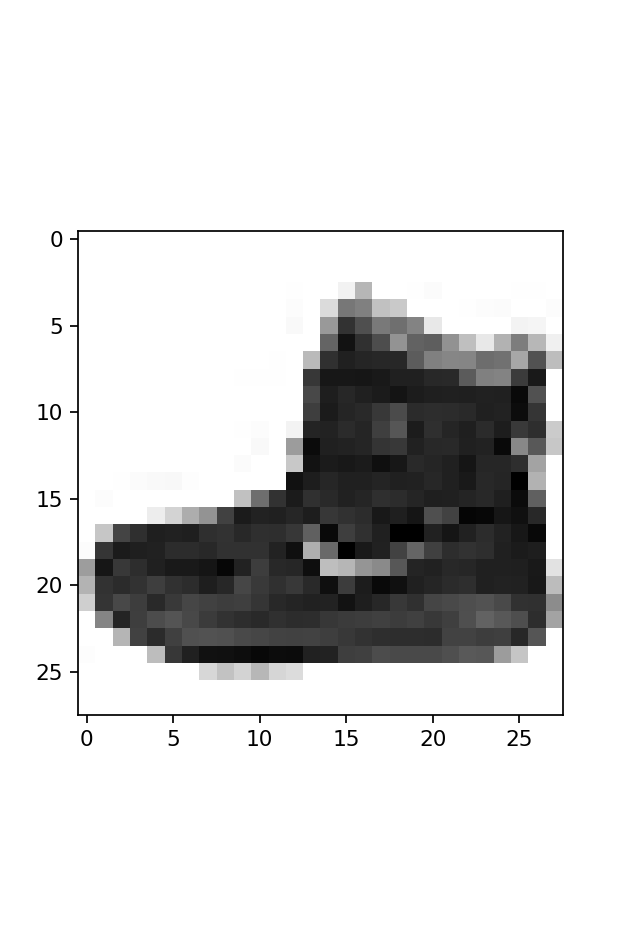

In [4]:
%matplotlib notebook
from matplotlib.pyplot import figure
figure(figsize=(4, 6),dpi=100)

import matplotlib.pyplot as plt
# plot raw pixel data
plt.imshow(trainX[0], cmap='gray_r')

<IPython.core.display.Javascript object>


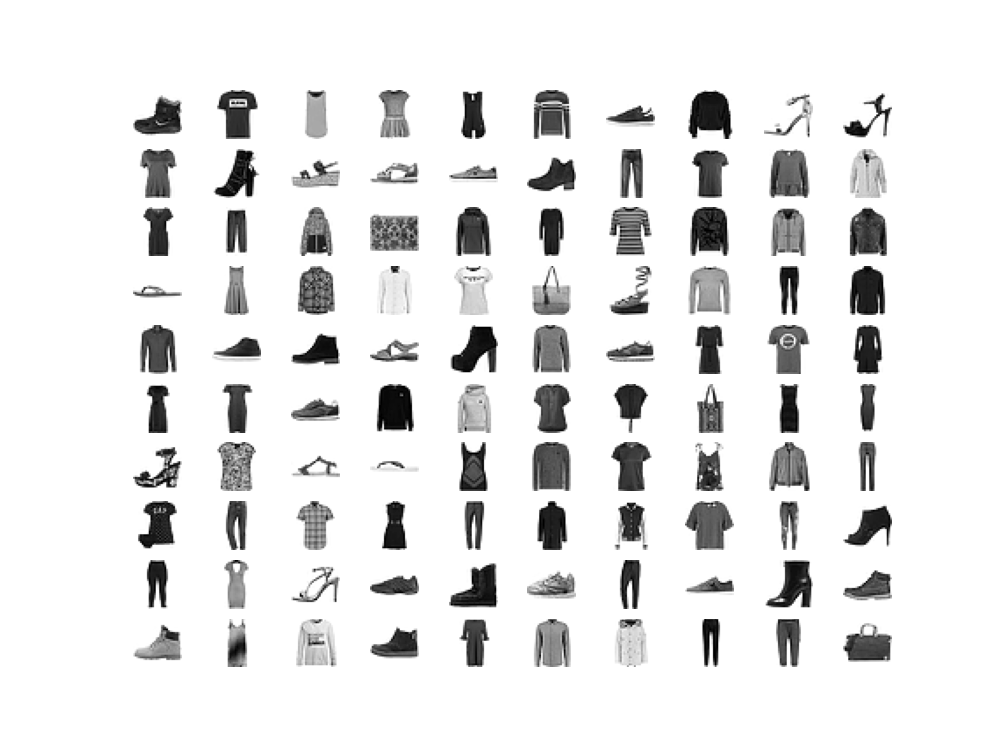

In [6]:
from matplotlib import pyplot
for i in range(100):
 # define subplot
 pyplot.subplot(10, 10, 1 + i)
 # turn off axis
 pyplot.axis('off')
 # plot raw pixel data
 pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

# Unconditional GAN (DCGAN)

In [7]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

# Define the standalone discriminator model

In [8]:

def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model
 

# Define the standalone generator model

In [9]:

def define_generator(latent_dim):
    model = Sequential()
     # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
     # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    model.summary()
    return model
 

# Define the combined generator and discriminator model, for updating the generator

In [56]:

def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    model.summary()
    return model

# Load fashion mnist images (TRAINING SET)

In [8]:
def load_real_samples():
    # load dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

# Select real samples

In [9]:

def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [10]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [11]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y

In [17]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=2000):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            # save the generator model
            g_model.save('generator.h5')

In [58]:
# size of the latent space
latent_dim = 100
# create the discriminator
print('Discriminator')
discriminator = define_discriminator()
# create the generator
print('Generator')
generator = define_generator(latent_dim)
# create the gan
print('GAN')
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()

Discriminator
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 14, 14, 128)       1280      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1) 

In [18]:

# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

>1, 1/30, d1=0.710, d2=0.695 g=0.691
>1, 2/30, d1=0.644, d2=0.699 g=0.688
>1, 3/30, d1=0.590, d2=0.704 g=0.684
>1, 4/30, d1=0.540, d2=0.709 g=0.680
>1, 5/30, d1=0.491, d2=0.715 g=0.676
>1, 6/30, d1=0.441, d2=0.722 g=0.672
>1, 7/30, d1=0.395, d2=0.732 g=0.664
>1, 8/30, d1=0.354, d2=0.759 g=0.645
>1, 9/30, d1=0.313, d2=0.807 g=0.616
>1, 10/30, d1=0.291, d2=0.856 g=0.595
>1, 11/30, d1=0.280, d2=0.869 g=0.613
>1, 12/30, d1=0.286, d2=0.807 g=0.687
>1, 13/30, d1=0.299, d2=0.696 g=0.806
>1, 14/30, d1=0.305, d2=0.582 g=0.943
>1, 15/30, d1=0.314, d2=0.496 g=1.054
>1, 16/30, d1=0.316, d2=0.463 g=1.086
>1, 17/30, d1=0.324, d2=0.480 g=1.027
>1, 18/30, d1=0.301, d2=0.523 g=0.934
>1, 19/30, d1=0.289, d2=0.581 g=0.839
>1, 20/30, d1=0.264, d2=0.639 g=0.766
>1, 21/30, d1=0.247, d2=0.705 g=0.698
>1, 22/30, d1=0.228, d2=0.807 g=0.615
>1, 23/30, d1=0.210, d2=0.930 g=0.541
>1, 24/30, d1=0.170, d2=1.082 g=0.474
>1, 25/30, d1=0.150, d2=1.185 g=0.452
>1, 26/30, d1=0.127, d2=1.152 g=0.501
>1, 27/30, d1=0.117, 

>2, 11/30, d1=0.070, d2=1.032 g=0.516
>2, 12/30, d1=0.093, d2=0.950 g=0.598
>2, 13/30, d1=0.122, d2=0.794 g=0.732
>2, 14/30, d1=0.154, d2=0.642 g=0.894
>2, 15/30, d1=0.181, d2=0.536 g=1.022
>2, 16/30, d1=0.222, d2=0.504 g=1.035
>2, 17/30, d1=0.229, d2=0.520 g=0.964
>2, 18/30, d1=0.232, d2=0.575 g=0.864
>2, 19/30, d1=0.222, d2=0.640 g=0.778
>2, 20/30, d1=0.191, d2=0.690 g=0.715
>2, 21/30, d1=0.175, d2=0.730 g=0.676
>2, 22/30, d1=0.162, d2=0.758 g=0.655
>2, 23/30, d1=0.130, d2=0.773 g=0.642
>2, 24/30, d1=0.118, d2=0.789 g=0.634
>2, 25/30, d1=0.113, d2=0.804 g=0.624
>2, 26/30, d1=0.105, d2=0.822 g=0.614
>2, 27/30, d1=0.111, d2=0.849 g=0.602
>2, 28/30, d1=0.121, d2=0.872 g=0.590
>2, 29/30, d1=0.129, d2=0.891 g=0.584
>2, 30/30, d1=0.154, d2=0.908 g=0.585
>3, 1/30, d1=0.184, d2=0.902 g=0.588
>3, 2/30, d1=0.209, d2=0.903 g=0.590
>3, 3/30, d1=0.221, d2=0.903 g=0.595
>3, 4/30, d1=0.266, d2=0.907 g=0.591
>3, 5/30, d1=0.266, d2=0.912 g=0.585
>3, 6/30, d1=0.274, d2=0.913 g=0.589
>3, 7/30, d1=0.288

>3, 21/30, d1=0.710, d2=0.849 g=0.706
>3, 22/30, d1=0.706, d2=0.981 g=0.599
>3, 23/30, d1=0.709, d2=1.083 g=0.555
>3, 24/30, d1=0.681, d2=1.023 g=0.623
>3, 25/30, d1=0.630, d2=0.796 g=0.816
>3, 26/30, d1=0.553, d2=0.559 g=1.065
>3, 27/30, d1=0.478, d2=0.461 g=1.180
>3, 28/30, d1=0.417, d2=0.545 g=1.029
>3, 29/30, d1=0.402, d2=0.877 g=0.739
>3, 30/30, d1=0.420, d2=1.217 g=0.607
>4, 1/30, d1=0.523, d2=1.149 g=0.712
>4, 2/30, d1=0.669, d2=0.795 g=0.987
>4, 3/30, d1=0.798, d2=0.503 g=1.254
>4, 4/30, d1=0.842, d2=0.374 g=1.400
>4, 5/30, d1=0.819, d2=0.324 g=1.479
>4, 6/30, d1=0.736, d2=0.296 g=1.534
>4, 7/30, d1=0.701, d2=0.279 g=1.573
>4, 8/30, d1=0.637, d2=0.267 g=1.609
>4, 9/30, d1=0.600, d2=0.254 g=1.648
>4, 10/30, d1=0.550, d2=0.244 g=1.684
>4, 11/30, d1=0.530, d2=0.232 g=1.725
>4, 12/30, d1=0.512, d2=0.224 g=1.751
>4, 13/30, d1=0.476, d2=0.218 g=1.775
>4, 14/30, d1=0.460, d2=0.213 g=1.793
>4, 15/30, d1=0.438, d2=0.213 g=1.797
>4, 16/30, d1=0.426, d2=0.219 g=1.779
>4, 17/30, d1=0.419, 

>5, 1/30, d1=0.437, d2=1.027 g=0.663
>5, 2/30, d1=0.524, d2=1.106 g=0.635
>5, 3/30, d1=0.702, d2=1.088 g=0.640
>5, 4/30, d1=0.812, d2=0.994 g=0.685
>5, 5/30, d1=0.921, d2=0.882 g=0.771
>5, 6/30, d1=1.006, d2=0.748 g=0.877
>5, 7/30, d1=1.029, d2=0.630 g=0.991
>5, 8/30, d1=1.023, d2=0.534 g=1.096
>5, 9/30, d1=0.991, d2=0.471 g=1.198
>5, 10/30, d1=0.933, d2=0.425 g=1.289
>5, 11/30, d1=0.881, d2=0.389 g=1.360
>5, 12/30, d1=0.826, d2=0.372 g=1.397
>5, 13/30, d1=0.781, d2=0.372 g=1.418
>5, 14/30, d1=0.724, d2=0.375 g=1.439
>5, 15/30, d1=0.702, d2=0.385 g=1.464
>5, 16/30, d1=0.662, d2=0.368 g=1.511
>5, 17/30, d1=0.641, d2=0.349 g=1.517
>5, 18/30, d1=0.612, d2=0.374 g=1.457
>5, 19/30, d1=0.576, d2=0.418 g=1.344
>5, 20/30, d1=0.534, d2=0.459 g=1.244
>5, 21/30, d1=0.519, d2=0.476 g=1.210
>5, 22/30, d1=0.506, d2=0.477 g=1.195
>5, 23/30, d1=0.492, d2=0.476 g=1.192
>5, 24/30, d1=0.517, d2=0.491 g=1.162
>5, 25/30, d1=0.530, d2=0.517 g=1.100
>5, 26/30, d1=0.543, d2=0.578 g=0.995
>5, 27/30, d1=0.584, 

>6, 11/30, d1=0.752, d2=0.521 g=1.004
>6, 12/30, d1=0.738, d2=0.535 g=0.981
>6, 13/30, d1=0.727, d2=0.554 g=0.944
>6, 14/30, d1=0.698, d2=0.596 g=0.893
>6, 15/30, d1=0.684, d2=0.638 g=0.837
>6, 16/30, d1=0.683, d2=0.679 g=0.778
>6, 17/30, d1=0.678, d2=0.731 g=0.730
>6, 18/30, d1=0.667, d2=0.771 g=0.693
>6, 19/30, d1=0.674, d2=0.801 g=0.672
>6, 20/30, d1=0.670, d2=0.809 g=0.660
>6, 21/30, d1=0.639, d2=0.803 g=0.664
>6, 22/30, d1=0.636, d2=0.797 g=0.679
>6, 23/30, d1=0.625, d2=0.778 g=0.691
>6, 24/30, d1=0.609, d2=0.753 g=0.710
>6, 25/30, d1=0.598, d2=0.737 g=0.731
>6, 26/30, d1=0.585, d2=0.720 g=0.755
>6, 27/30, d1=0.573, d2=0.698 g=0.768
>6, 28/30, d1=0.565, d2=0.679 g=0.783
>6, 29/30, d1=0.555, d2=0.683 g=0.781
>6, 30/30, d1=0.555, d2=0.693 g=0.768
>7, 1/30, d1=0.545, d2=0.713 g=0.748
>7, 2/30, d1=0.537, d2=0.733 g=0.728
>7, 3/30, d1=0.545, d2=0.766 g=0.704
>7, 4/30, d1=0.561, d2=0.787 g=0.681
>7, 5/30, d1=0.574, d2=0.802 g=0.678
>7, 6/30, d1=0.589, d2=0.803 g=0.682
>7, 7/30, d1=0.588

>7, 21/30, d1=0.666, d2=0.619 g=0.855
>7, 22/30, d1=0.635, d2=0.648 g=0.825
>7, 23/30, d1=0.639, d2=0.680 g=0.790
>7, 24/30, d1=0.640, d2=0.705 g=0.754
>7, 25/30, d1=0.639, d2=0.733 g=0.730
>7, 26/30, d1=0.629, d2=0.763 g=0.711
>7, 27/30, d1=0.625, d2=0.775 g=0.695
>7, 28/30, d1=0.621, d2=0.775 g=0.689
>7, 29/30, d1=0.609, d2=0.786 g=0.685
>7, 30/30, d1=0.619, d2=0.785 g=0.684
>8, 1/30, d1=0.608, d2=0.785 g=0.691
>8, 2/30, d1=0.594, d2=0.778 g=0.699
>8, 3/30, d1=0.579, d2=0.771 g=0.709
>8, 4/30, d1=0.591, d2=0.764 g=0.712
>8, 5/30, d1=0.582, d2=0.771 g=0.704
>8, 6/30, d1=0.583, d2=0.789 g=0.685
>8, 7/30, d1=0.605, d2=0.820 g=0.653
>8, 8/30, d1=0.616, d2=0.867 g=0.619
>8, 9/30, d1=0.611, d2=0.895 g=0.593
>8, 10/30, d1=0.636, d2=0.921 g=0.579
>8, 11/30, d1=0.637, d2=0.926 g=0.583
>8, 12/30, d1=0.645, d2=0.899 g=0.600
>8, 13/30, d1=0.650, d2=0.862 g=0.635
>8, 14/30, d1=0.674, d2=0.822 g=0.669
>8, 15/30, d1=0.688, d2=0.776 g=0.704
>8, 16/30, d1=0.684, d2=0.739 g=0.738
>8, 17/30, d1=0.692, 

>9, 1/30, d1=0.645, d2=0.845 g=0.614
>9, 2/30, d1=0.643, d2=0.885 g=0.583
>9, 3/30, d1=0.649, d2=0.908 g=0.565
>9, 4/30, d1=0.647, d2=0.922 g=0.558
>9, 5/30, d1=0.642, d2=0.915 g=0.567
>9, 6/30, d1=0.652, d2=0.892 g=0.584
>9, 7/30, d1=0.651, d2=0.864 g=0.609
>9, 8/30, d1=0.647, d2=0.826 g=0.639
>9, 9/30, d1=0.635, d2=0.782 g=0.674
>9, 10/30, d1=0.633, d2=0.744 g=0.710
>9, 11/30, d1=0.623, d2=0.718 g=0.742
>9, 12/30, d1=0.617, d2=0.700 g=0.760
>9, 13/30, d1=0.610, d2=0.692 g=0.771
>9, 14/30, d1=0.606, d2=0.687 g=0.768
>9, 15/30, d1=0.602, d2=0.709 g=0.751
>9, 16/30, d1=0.616, d2=0.726 g=0.729
>9, 17/30, d1=0.616, d2=0.748 g=0.714
>9, 18/30, d1=0.621, d2=0.767 g=0.695
>9, 19/30, d1=0.642, d2=0.777 g=0.688
>9, 20/30, d1=0.658, d2=0.778 g=0.694
>9, 21/30, d1=0.685, d2=0.764 g=0.709
>9, 22/30, d1=0.693, d2=0.749 g=0.729
>9, 23/30, d1=0.707, d2=0.717 g=0.753
>9, 24/30, d1=0.720, d2=0.689 g=0.776
>9, 25/30, d1=0.731, d2=0.666 g=0.800
>9, 26/30, d1=0.741, d2=0.644 g=0.816
>9, 27/30, d1=0.744, 

>10, 11/30, d1=0.720, d2=0.711 g=0.741
>10, 12/30, d1=0.714, d2=0.686 g=0.761
>10, 13/30, d1=0.701, d2=0.663 g=0.787
>10, 14/30, d1=0.696, d2=0.645 g=0.805
>10, 15/30, d1=0.682, d2=0.634 g=0.819
>10, 16/30, d1=0.667, d2=0.629 g=0.828
>10, 17/30, d1=0.664, d2=0.629 g=0.828
>10, 18/30, d1=0.665, d2=0.637 g=0.815
>10, 19/30, d1=0.652, d2=0.654 g=0.801
>10, 20/30, d1=0.656, d2=0.670 g=0.774
>10, 21/30, d1=0.649, d2=0.699 g=0.751
>10, 22/30, d1=0.662, d2=0.716 g=0.731
>10, 23/30, d1=0.682, d2=0.734 g=0.719
>10, 24/30, d1=0.690, d2=0.739 g=0.720
>10, 25/30, d1=0.687, d2=0.730 g=0.727
>10, 26/30, d1=0.698, d2=0.715 g=0.741
>10, 27/30, d1=0.705, d2=0.695 g=0.765
>10, 28/30, d1=0.706, d2=0.667 g=0.790
>10, 29/30, d1=0.718, d2=0.644 g=0.813
>10, 30/30, d1=0.719, d2=0.624 g=0.832
>11, 1/30, d1=0.717, d2=0.609 g=0.847
>11, 2/30, d1=0.714, d2=0.602 g=0.853
>11, 3/30, d1=0.712, d2=0.599 g=0.852
>11, 4/30, d1=0.711, d2=0.612 g=0.832
>11, 5/30, d1=0.713, d2=0.636 g=0.809
>11, 6/30, d1=0.712, d2=0.657 

>11, 21/30, d1=0.713, d2=0.613 g=0.851
>11, 22/30, d1=0.717, d2=0.634 g=0.824
>11, 23/30, d1=0.703, d2=0.655 g=0.797
>11, 24/30, d1=0.708, d2=0.680 g=0.771
>11, 25/30, d1=0.713, d2=0.703 g=0.745
>11, 26/30, d1=0.723, d2=0.717 g=0.737
>11, 27/30, d1=0.705, d2=0.714 g=0.731
>11, 28/30, d1=0.713, d2=0.709 g=0.738
>11, 29/30, d1=0.713, d2=0.699 g=0.748
>11, 30/30, d1=0.720, d2=0.680 g=0.760
>12, 1/30, d1=0.724, d2=0.660 g=0.792
>12, 2/30, d1=0.713, d2=0.635 g=0.816
>12, 3/30, d1=0.723, d2=0.618 g=0.838
>12, 4/30, d1=0.720, d2=0.604 g=0.849
>12, 5/30, d1=0.706, d2=0.594 g=0.858
>12, 6/30, d1=0.709, d2=0.598 g=0.854
>12, 7/30, d1=0.712, d2=0.608 g=0.844
>12, 8/30, d1=0.700, d2=0.632 g=0.821
>12, 9/30, d1=0.701, d2=0.652 g=0.792
>12, 10/30, d1=0.706, d2=0.674 g=0.758
>12, 11/30, d1=0.698, d2=0.710 g=0.729
>12, 12/30, d1=0.714, d2=0.743 g=0.707
>12, 13/30, d1=0.704, d2=0.755 g=0.694
>12, 14/30, d1=0.716, d2=0.755 g=0.687
>12, 15/30, d1=0.713, d2=0.754 g=0.679
>12, 16/30, d1=0.702, d2=0.753 g=0

>13, 1/30, d1=0.676, d2=0.697 g=0.738
>13, 2/30, d1=0.679, d2=0.695 g=0.737
>13, 3/30, d1=0.675, d2=0.694 g=0.738
>13, 4/30, d1=0.683, d2=0.688 g=0.741
>13, 5/30, d1=0.680, d2=0.684 g=0.747
>13, 6/30, d1=0.681, d2=0.677 g=0.754
>13, 7/30, d1=0.684, d2=0.671 g=0.762
>13, 8/30, d1=0.685, d2=0.662 g=0.770
>13, 9/30, d1=0.689, d2=0.658 g=0.775
>13, 10/30, d1=0.691, d2=0.660 g=0.784
>13, 11/30, d1=0.693, d2=0.656 g=0.788
>13, 12/30, d1=0.689, d2=0.656 g=0.781
>13, 13/30, d1=0.695, d2=0.647 g=0.784
>13, 14/30, d1=0.691, d2=0.656 g=0.784
>13, 15/30, d1=0.696, d2=0.660 g=0.777
>13, 16/30, d1=0.690, d2=0.659 g=0.778
>13, 17/30, d1=0.689, d2=0.674 g=0.772
>13, 18/30, d1=0.688, d2=0.672 g=0.767
>13, 19/30, d1=0.690, d2=0.668 g=0.766
>13, 20/30, d1=0.703, d2=0.671 g=0.764
>13, 21/30, d1=0.697, d2=0.675 g=0.768
>13, 22/30, d1=0.690, d2=0.679 g=0.768
>13, 23/30, d1=0.698, d2=0.672 g=0.772
>13, 24/30, d1=0.694, d2=0.665 g=0.776
>13, 25/30, d1=0.700, d2=0.658 g=0.779
>13, 26/30, d1=0.701, d2=0.661 g=0

>14, 11/30, d1=0.697, d2=0.678 g=0.749
>14, 12/30, d1=0.688, d2=0.679 g=0.747
>14, 13/30, d1=0.686, d2=0.680 g=0.748
>14, 14/30, d1=0.691, d2=0.677 g=0.750
>14, 15/30, d1=0.692, d2=0.678 g=0.747
>14, 16/30, d1=0.683, d2=0.680 g=0.746
>14, 17/30, d1=0.681, d2=0.680 g=0.746
>14, 18/30, d1=0.682, d2=0.686 g=0.741
>14, 19/30, d1=0.685, d2=0.688 g=0.736
>14, 20/30, d1=0.691, d2=0.693 g=0.738
>14, 21/30, d1=0.686, d2=0.697 g=0.732
>14, 22/30, d1=0.686, d2=0.698 g=0.729
>14, 23/30, d1=0.682, d2=0.701 g=0.724
>14, 24/30, d1=0.689, d2=0.704 g=0.728
>14, 25/30, d1=0.689, d2=0.701 g=0.722
>14, 26/30, d1=0.697, d2=0.705 g=0.729
>14, 27/30, d1=0.696, d2=0.699 g=0.728
>14, 28/30, d1=0.695, d2=0.700 g=0.728
>14, 29/30, d1=0.699, d2=0.692 g=0.735
>14, 30/30, d1=0.694, d2=0.691 g=0.737
>15, 1/30, d1=0.696, d2=0.686 g=0.741
>15, 2/30, d1=0.698, d2=0.683 g=0.744
>15, 3/30, d1=0.700, d2=0.679 g=0.748
>15, 4/30, d1=0.704, d2=0.676 g=0.755
>15, 5/30, d1=0.704, d2=0.672 g=0.757
>15, 6/30, d1=0.705, d2=0.668 

>15, 21/30, d1=0.685, d2=0.680 g=0.742
>15, 22/30, d1=0.681, d2=0.684 g=0.735
>15, 23/30, d1=0.677, d2=0.693 g=0.729
>15, 24/30, d1=0.676, d2=0.695 g=0.725
>15, 25/30, d1=0.676, d2=0.692 g=0.724
>15, 26/30, d1=0.679, d2=0.700 g=0.720
>15, 27/30, d1=0.678, d2=0.703 g=0.717
>15, 28/30, d1=0.673, d2=0.711 g=0.717
>15, 29/30, d1=0.674, d2=0.708 g=0.715
>15, 30/30, d1=0.673, d2=0.709 g=0.712
>16, 1/30, d1=0.676, d2=0.708 g=0.712
>16, 2/30, d1=0.673, d2=0.707 g=0.710
>16, 3/30, d1=0.675, d2=0.712 g=0.714
>16, 4/30, d1=0.681, d2=0.711 g=0.710
>16, 5/30, d1=0.680, d2=0.706 g=0.716
>16, 6/30, d1=0.680, d2=0.702 g=0.717
>16, 7/30, d1=0.682, d2=0.703 g=0.721
>16, 8/30, d1=0.683, d2=0.695 g=0.727
>16, 9/30, d1=0.685, d2=0.698 g=0.732
>16, 10/30, d1=0.687, d2=0.695 g=0.735
>16, 11/30, d1=0.690, d2=0.691 g=0.737
>16, 12/30, d1=0.689, d2=0.692 g=0.738
>16, 13/30, d1=0.692, d2=0.692 g=0.731
>16, 14/30, d1=0.694, d2=0.697 g=0.728
>16, 15/30, d1=0.693, d2=0.699 g=0.720
>16, 16/30, d1=0.694, d2=0.713 g=0

>17, 1/30, d1=0.682, d2=0.702 g=0.716
>17, 2/30, d1=0.671, d2=0.711 g=0.713
>17, 3/30, d1=0.680, d2=0.715 g=0.706
>17, 4/30, d1=0.677, d2=0.718 g=0.699
>17, 5/30, d1=0.675, d2=0.731 g=0.699
>17, 6/30, d1=0.684, d2=0.730 g=0.696
>17, 7/30, d1=0.682, d2=0.728 g=0.701
>17, 8/30, d1=0.689, d2=0.730 g=0.710
>17, 9/30, d1=0.688, d2=0.713 g=0.721
>17, 10/30, d1=0.691, d2=0.695 g=0.739
>17, 11/30, d1=0.695, d2=0.678 g=0.762
>17, 12/30, d1=0.697, d2=0.657 g=0.787
>17, 13/30, d1=0.700, d2=0.636 g=0.807
>17, 14/30, d1=0.705, d2=0.618 g=0.821
>17, 15/30, d1=0.701, d2=0.617 g=0.825
>17, 16/30, d1=0.703, d2=0.628 g=0.812
>17, 17/30, d1=0.706, d2=0.640 g=0.785
>17, 18/30, d1=0.711, d2=0.680 g=0.747
>17, 19/30, d1=0.698, d2=0.709 g=0.710
>17, 20/30, d1=0.702, d2=0.748 g=0.679
>17, 21/30, d1=0.691, d2=0.771 g=0.660
>17, 22/30, d1=0.695, d2=0.780 g=0.653
>17, 23/30, d1=0.696, d2=0.774 g=0.659
>17, 24/30, d1=0.691, d2=0.763 g=0.671
>17, 25/30, d1=0.688, d2=0.740 g=0.694
>17, 26/30, d1=0.692, d2=0.713 g=0

>18, 11/30, d1=0.707, d2=0.767 g=0.678
>18, 12/30, d1=0.713, d2=0.736 g=0.720
>18, 13/30, d1=0.714, d2=0.698 g=0.765
>18, 14/30, d1=0.727, d2=0.648 g=0.820
>18, 15/30, d1=0.733, d2=0.607 g=0.867
>18, 16/30, d1=0.732, d2=0.578 g=0.895
>18, 17/30, d1=0.734, d2=0.565 g=0.912
>18, 18/30, d1=0.737, d2=0.568 g=0.900
>18, 19/30, d1=0.747, d2=0.586 g=0.874
>18, 20/30, d1=0.733, d2=0.607 g=0.836
>18, 21/30, d1=0.733, d2=0.638 g=0.802
>18, 22/30, d1=0.722, d2=0.665 g=0.763
>18, 23/30, d1=0.726, d2=0.686 g=0.734
>18, 24/30, d1=0.716, d2=0.713 g=0.714
>18, 25/30, d1=0.723, d2=0.726 g=0.702
>18, 26/30, d1=0.708, d2=0.727 g=0.697
>18, 27/30, d1=0.710, d2=0.721 g=0.706
>18, 28/30, d1=0.702, d2=0.704 g=0.718
>18, 29/30, d1=0.694, d2=0.691 g=0.738
>18, 30/30, d1=0.696, d2=0.667 g=0.757
>19, 1/30, d1=0.691, d2=0.653 g=0.775
>19, 2/30, d1=0.687, d2=0.637 g=0.792
>19, 3/30, d1=0.678, d2=0.628 g=0.800
>19, 4/30, d1=0.681, d2=0.624 g=0.802
>19, 5/30, d1=0.673, d2=0.630 g=0.795
>19, 6/30, d1=0.686, d2=0.647 

>19, 21/30, d1=0.713, d2=0.612 g=0.828
>19, 22/30, d1=0.714, d2=0.604 g=0.833
>19, 23/30, d1=0.713, d2=0.603 g=0.835
>19, 24/30, d1=0.717, d2=0.608 g=0.823
>19, 25/30, d1=0.717, d2=0.625 g=0.798
>19, 26/30, d1=0.709, d2=0.644 g=0.772
>19, 27/30, d1=0.716, d2=0.672 g=0.748
>19, 28/30, d1=0.709, d2=0.691 g=0.724
>19, 29/30, d1=0.705, d2=0.706 g=0.707
>19, 30/30, d1=0.706, d2=0.716 g=0.695
>20, 1/30, d1=0.696, d2=0.727 g=0.692
>20, 2/30, d1=0.697, d2=0.725 g=0.692
>20, 3/30, d1=0.692, d2=0.720 g=0.695
>20, 4/30, d1=0.688, d2=0.714 g=0.706
>20, 5/30, d1=0.688, d2=0.704 g=0.712
>20, 6/30, d1=0.690, d2=0.695 g=0.725
>20, 7/30, d1=0.681, d2=0.682 g=0.732
>20, 8/30, d1=0.680, d2=0.675 g=0.742
>20, 9/30, d1=0.676, d2=0.667 g=0.751
>20, 10/30, d1=0.674, d2=0.660 g=0.758
>20, 11/30, d1=0.671, d2=0.655 g=0.761
>20, 12/30, d1=0.671, d2=0.652 g=0.762
>20, 13/30, d1=0.670, d2=0.655 g=0.762
>20, 14/30, d1=0.668, d2=0.661 g=0.756
>20, 15/30, d1=0.665, d2=0.664 g=0.746
>20, 16/30, d1=0.662, d2=0.673 g=0

>21, 1/30, d1=0.696, d2=0.620 g=0.809
>21, 2/30, d1=0.704, d2=0.626 g=0.796
>21, 3/30, d1=0.700, d2=0.647 g=0.775
>21, 4/30, d1=0.691, d2=0.668 g=0.748
>21, 5/30, d1=0.696, d2=0.694 g=0.714
>21, 6/30, d1=0.695, d2=0.726 g=0.685
>21, 7/30, d1=0.690, d2=0.749 g=0.661
>21, 8/30, d1=0.687, d2=0.772 g=0.647
>21, 9/30, d1=0.681, d2=0.783 g=0.637
>21, 10/30, d1=0.681, d2=0.788 g=0.639
>21, 11/30, d1=0.675, d2=0.780 g=0.645
>21, 12/30, d1=0.671, d2=0.769 g=0.657
>21, 13/30, d1=0.667, d2=0.750 g=0.672
>21, 14/30, d1=0.668, d2=0.732 g=0.686
>21, 15/30, d1=0.673, d2=0.718 g=0.706
>21, 16/30, d1=0.667, d2=0.700 g=0.721
>21, 17/30, d1=0.667, d2=0.686 g=0.740
>21, 18/30, d1=0.666, d2=0.671 g=0.755
>21, 19/30, d1=0.661, d2=0.660 g=0.769
>21, 20/30, d1=0.663, d2=0.648 g=0.777
>21, 21/30, d1=0.658, d2=0.640 g=0.786
>21, 22/30, d1=0.659, d2=0.645 g=0.785
>21, 23/30, d1=0.667, d2=0.649 g=0.777
>21, 24/30, d1=0.660, d2=0.659 g=0.767
>21, 25/30, d1=0.660, d2=0.678 g=0.747
>21, 26/30, d1=0.660, d2=0.695 g=0

>22, 11/30, d1=0.713, d2=0.724 g=0.699
>22, 12/30, d1=0.713, d2=0.758 g=0.656
>22, 13/30, d1=0.718, d2=0.786 g=0.635
>22, 14/30, d1=0.717, d2=0.801 g=0.627
>22, 15/30, d1=0.710, d2=0.801 g=0.628
>22, 16/30, d1=0.700, d2=0.791 g=0.634
>22, 17/30, d1=0.689, d2=0.777 g=0.651
>22, 18/30, d1=0.689, d2=0.755 g=0.668
>22, 19/30, d1=0.683, d2=0.732 g=0.691
>22, 20/30, d1=0.682, d2=0.710 g=0.719
>22, 21/30, d1=0.680, d2=0.683 g=0.743
>22, 22/30, d1=0.679, d2=0.655 g=0.772
>22, 23/30, d1=0.680, d2=0.638 g=0.796
>22, 24/30, d1=0.672, d2=0.620 g=0.809
>22, 25/30, d1=0.663, d2=0.613 g=0.823
>22, 26/30, d1=0.670, d2=0.615 g=0.823
>22, 27/30, d1=0.670, d2=0.623 g=0.809
>22, 28/30, d1=0.663, d2=0.639 g=0.786
>22, 29/30, d1=0.676, d2=0.664 g=0.758
>22, 30/30, d1=0.661, d2=0.692 g=0.733
>23, 1/30, d1=0.672, d2=0.714 g=0.716
>23, 2/30, d1=0.682, d2=0.725 g=0.705
>23, 3/30, d1=0.691, d2=0.735 g=0.709
>23, 4/30, d1=0.692, d2=0.719 g=0.718
>23, 5/30, d1=0.702, d2=0.696 g=0.736
>23, 6/30, d1=0.706, d2=0.671 

>23, 21/30, d1=0.699, d2=0.766 g=0.649
>23, 22/30, d1=0.700, d2=0.762 g=0.651
>23, 23/30, d1=0.687, d2=0.759 g=0.658
>23, 24/30, d1=0.684, d2=0.752 g=0.666
>23, 25/30, d1=0.685, d2=0.741 g=0.678
>23, 26/30, d1=0.680, d2=0.731 g=0.691
>23, 27/30, d1=0.682, d2=0.714 g=0.702
>23, 28/30, d1=0.680, d2=0.699 g=0.719
>23, 29/30, d1=0.677, d2=0.689 g=0.731
>23, 30/30, d1=0.678, d2=0.675 g=0.743
>24, 1/30, d1=0.672, d2=0.661 g=0.759
>24, 2/30, d1=0.676, d2=0.655 g=0.763
>24, 3/30, d1=0.680, d2=0.652 g=0.768
>24, 4/30, d1=0.671, d2=0.653 g=0.768
>24, 5/30, d1=0.664, d2=0.655 g=0.759
>24, 6/30, d1=0.674, d2=0.668 g=0.751
>24, 7/30, d1=0.670, d2=0.685 g=0.735
>24, 8/30, d1=0.676, d2=0.696 g=0.724
>24, 9/30, d1=0.674, d2=0.709 g=0.715
>24, 10/30, d1=0.675, d2=0.710 g=0.712
>24, 11/30, d1=0.691, d2=0.709 g=0.710
>24, 12/30, d1=0.688, d2=0.705 g=0.713
>24, 13/30, d1=0.700, d2=0.696 g=0.728
>24, 14/30, d1=0.702, d2=0.678 g=0.748
>24, 15/30, d1=0.703, d2=0.658 g=0.767
>24, 16/30, d1=0.706, d2=0.648 g=0

>25, 1/30, d1=0.683, d2=0.705 g=0.709
>25, 2/30, d1=0.683, d2=0.693 g=0.721
>25, 3/30, d1=0.681, d2=0.680 g=0.735
>25, 4/30, d1=0.682, d2=0.669 g=0.747
>25, 5/30, d1=0.673, d2=0.657 g=0.755
>25, 6/30, d1=0.675, d2=0.653 g=0.764
>25, 7/30, d1=0.671, d2=0.646 g=0.767
>25, 8/30, d1=0.669, d2=0.643 g=0.768
>25, 9/30, d1=0.668, d2=0.644 g=0.771
>25, 10/30, d1=0.665, d2=0.645 g=0.769
>25, 11/30, d1=0.657, d2=0.649 g=0.766
>25, 12/30, d1=0.659, d2=0.657 g=0.755
>25, 13/30, d1=0.661, d2=0.665 g=0.746
>25, 14/30, d1=0.664, d2=0.672 g=0.736
>25, 15/30, d1=0.660, d2=0.679 g=0.726
>25, 16/30, d1=0.655, d2=0.699 g=0.717
>25, 17/30, d1=0.657, d2=0.705 g=0.707
>25, 18/30, d1=0.658, d2=0.710 g=0.702
>25, 19/30, d1=0.660, d2=0.716 g=0.702
>25, 20/30, d1=0.673, d2=0.711 g=0.704
>25, 21/30, d1=0.669, d2=0.706 g=0.712
>25, 22/30, d1=0.679, d2=0.699 g=0.721
>25, 23/30, d1=0.687, d2=0.685 g=0.731
>25, 24/30, d1=0.695, d2=0.675 g=0.747
>25, 25/30, d1=0.697, d2=0.660 g=0.768
>25, 26/30, d1=0.703, d2=0.648 g=0

>26, 11/30, d1=0.687, d2=0.702 g=0.708
>26, 12/30, d1=0.690, d2=0.696 g=0.715
>26, 13/30, d1=0.684, d2=0.686 g=0.720
>26, 14/30, d1=0.679, d2=0.682 g=0.728
>26, 15/30, d1=0.677, d2=0.673 g=0.736
>26, 16/30, d1=0.675, d2=0.669 g=0.740
>26, 17/30, d1=0.668, d2=0.665 g=0.747
>26, 18/30, d1=0.671, d2=0.662 g=0.750
>26, 19/30, d1=0.666, d2=0.658 g=0.754
>26, 20/30, d1=0.663, d2=0.658 g=0.753
>26, 21/30, d1=0.663, d2=0.664 g=0.750
>26, 22/30, d1=0.663, d2=0.662 g=0.746
>26, 23/30, d1=0.664, d2=0.671 g=0.742
>26, 24/30, d1=0.666, d2=0.678 g=0.733
>26, 25/30, d1=0.666, d2=0.687 g=0.723
>26, 26/30, d1=0.660, d2=0.700 g=0.715
>26, 27/30, d1=0.668, d2=0.703 g=0.711
>26, 28/30, d1=0.671, d2=0.709 g=0.706
>26, 29/30, d1=0.670, d2=0.711 g=0.705
>26, 30/30, d1=0.679, d2=0.707 g=0.709
>27, 1/30, d1=0.684, d2=0.703 g=0.715
>27, 2/30, d1=0.688, d2=0.696 g=0.728
>27, 3/30, d1=0.691, d2=0.682 g=0.745
>27, 4/30, d1=0.698, d2=0.667 g=0.763
>27, 5/30, d1=0.704, d2=0.647 g=0.781
>27, 6/30, d1=0.711, d2=0.630 

>27, 21/30, d1=0.702, d2=0.703 g=0.707
>27, 22/30, d1=0.695, d2=0.697 g=0.712
>27, 23/30, d1=0.693, d2=0.690 g=0.718
>27, 24/30, d1=0.692, d2=0.686 g=0.725
>27, 25/30, d1=0.683, d2=0.676 g=0.731
>27, 26/30, d1=0.685, d2=0.676 g=0.736
>27, 27/30, d1=0.684, d2=0.667 g=0.739
>27, 28/30, d1=0.679, d2=0.671 g=0.741
>27, 29/30, d1=0.673, d2=0.668 g=0.739
>27, 30/30, d1=0.669, d2=0.672 g=0.737
>28, 1/30, d1=0.675, d2=0.684 g=0.732
>28, 2/30, d1=0.681, d2=0.688 g=0.726
>28, 3/30, d1=0.674, d2=0.699 g=0.713
>28, 4/30, d1=0.681, d2=0.709 g=0.710
>28, 5/30, d1=0.694, d2=0.713 g=0.702
>28, 6/30, d1=0.693, d2=0.714 g=0.703
>28, 7/30, d1=0.699, d2=0.718 g=0.709
>28, 8/30, d1=0.699, d2=0.710 g=0.713
>28, 9/30, d1=0.707, d2=0.704 g=0.727
>28, 10/30, d1=0.708, d2=0.685 g=0.742
>28, 11/30, d1=0.720, d2=0.669 g=0.761
>28, 12/30, d1=0.722, d2=0.655 g=0.781
>28, 13/30, d1=0.726, d2=0.637 g=0.795
>28, 14/30, d1=0.732, d2=0.623 g=0.813
>28, 15/30, d1=0.741, d2=0.611 g=0.829
>28, 16/30, d1=0.744, d2=0.600 g=0

>29, 1/30, d1=0.681, d2=0.698 g=0.712
>29, 2/30, d1=0.675, d2=0.697 g=0.712
>29, 3/30, d1=0.673, d2=0.695 g=0.714
>29, 4/30, d1=0.674, d2=0.690 g=0.716
>29, 5/30, d1=0.670, d2=0.692 g=0.717
>29, 6/30, d1=0.667, d2=0.691 g=0.716
>29, 7/30, d1=0.669, d2=0.689 g=0.716
>29, 8/30, d1=0.669, d2=0.696 g=0.715
>29, 9/30, d1=0.665, d2=0.694 g=0.716
>29, 10/30, d1=0.665, d2=0.694 g=0.712
>29, 11/30, d1=0.668, d2=0.694 g=0.712
>29, 12/30, d1=0.667, d2=0.694 g=0.711
>29, 13/30, d1=0.666, d2=0.697 g=0.712
>29, 14/30, d1=0.668, d2=0.697 g=0.713
>29, 15/30, d1=0.668, d2=0.695 g=0.715
>29, 16/30, d1=0.671, d2=0.695 g=0.717
>29, 17/30, d1=0.667, d2=0.690 g=0.720
>29, 18/30, d1=0.669, d2=0.686 g=0.721
>29, 19/30, d1=0.678, d2=0.686 g=0.723
>29, 20/30, d1=0.676, d2=0.685 g=0.724
>29, 21/30, d1=0.675, d2=0.684 g=0.729
>29, 22/30, d1=0.675, d2=0.682 g=0.727
>29, 23/30, d1=0.681, d2=0.685 g=0.731
>29, 24/30, d1=0.684, d2=0.682 g=0.731
>29, 25/30, d1=0.683, d2=0.681 g=0.730
>29, 26/30, d1=0.684, d2=0.683 g=0

>30, 11/30, d1=0.689, d2=0.677 g=0.729
>30, 12/30, d1=0.690, d2=0.677 g=0.731
>30, 13/30, d1=0.687, d2=0.676 g=0.727
>30, 14/30, d1=0.688, d2=0.680 g=0.728
>30, 15/30, d1=0.686, d2=0.680 g=0.725
>30, 16/30, d1=0.686, d2=0.681 g=0.721
>30, 17/30, d1=0.684, d2=0.687 g=0.723
>30, 18/30, d1=0.682, d2=0.686 g=0.722
>30, 19/30, d1=0.682, d2=0.689 g=0.717
>30, 20/30, d1=0.682, d2=0.687 g=0.716
>30, 21/30, d1=0.684, d2=0.692 g=0.717
>30, 22/30, d1=0.683, d2=0.692 g=0.715
>30, 23/30, d1=0.681, d2=0.693 g=0.716
>30, 24/30, d1=0.685, d2=0.692 g=0.714
>30, 25/30, d1=0.679, d2=0.692 g=0.715
>30, 26/30, d1=0.680, d2=0.689 g=0.715
>30, 27/30, d1=0.685, d2=0.688 g=0.717
>30, 28/30, d1=0.687, d2=0.687 g=0.722
>30, 29/30, d1=0.682, d2=0.686 g=0.723
>30, 30/30, d1=0.684, d2=0.682 g=0.725
>31, 1/30, d1=0.685, d2=0.683 g=0.725
>31, 2/30, d1=0.686, d2=0.681 g=0.726
>31, 3/30, d1=0.681, d2=0.683 g=0.724
>31, 4/30, d1=0.685, d2=0.680 g=0.725
>31, 5/30, d1=0.682, d2=0.683 g=0.726
>31, 6/30, d1=0.681, d2=0.680 

>31, 21/30, d1=0.660, d2=0.696 g=0.711
>31, 22/30, d1=0.661, d2=0.696 g=0.710
>31, 23/30, d1=0.655, d2=0.697 g=0.707
>31, 24/30, d1=0.656, d2=0.701 g=0.706
>31, 25/30, d1=0.656, d2=0.700 g=0.705
>31, 26/30, d1=0.659, d2=0.702 g=0.706
>31, 27/30, d1=0.660, d2=0.709 g=0.704
>31, 28/30, d1=0.661, d2=0.702 g=0.704
>31, 29/30, d1=0.661, d2=0.700 g=0.707
>31, 30/30, d1=0.668, d2=0.701 g=0.708
>32, 1/30, d1=0.668, d2=0.700 g=0.713
>32, 2/30, d1=0.672, d2=0.697 g=0.717
>32, 3/30, d1=0.671, d2=0.690 g=0.717
>32, 4/30, d1=0.671, d2=0.691 g=0.720
>32, 5/30, d1=0.672, d2=0.685 g=0.721
>32, 6/30, d1=0.674, d2=0.689 g=0.723
>32, 7/30, d1=0.681, d2=0.685 g=0.721
>32, 8/30, d1=0.678, d2=0.688 g=0.724
>32, 9/30, d1=0.683, d2=0.689 g=0.722
>32, 10/30, d1=0.681, d2=0.692 g=0.723
>32, 11/30, d1=0.683, d2=0.685 g=0.722
>32, 12/30, d1=0.688, d2=0.686 g=0.722
>32, 13/30, d1=0.688, d2=0.685 g=0.726
>32, 14/30, d1=0.691, d2=0.683 g=0.728
>32, 15/30, d1=0.694, d2=0.679 g=0.735
>32, 16/30, d1=0.697, d2=0.675 g=0

>33, 1/30, d1=0.699, d2=0.662 g=0.751
>33, 2/30, d1=0.701, d2=0.658 g=0.755
>33, 3/30, d1=0.703, d2=0.655 g=0.759
>33, 4/30, d1=0.705, d2=0.654 g=0.762
>33, 5/30, d1=0.702, d2=0.651 g=0.764
>33, 6/30, d1=0.703, d2=0.649 g=0.763
>33, 7/30, d1=0.704, d2=0.653 g=0.762
>33, 8/30, d1=0.705, d2=0.655 g=0.761
>33, 9/30, d1=0.705, d2=0.660 g=0.756
>33, 10/30, d1=0.705, d2=0.657 g=0.750
>33, 11/30, d1=0.707, d2=0.663 g=0.751
>33, 12/30, d1=0.709, d2=0.665 g=0.747
>33, 13/30, d1=0.712, d2=0.666 g=0.750
>33, 14/30, d1=0.715, d2=0.661 g=0.751
>33, 15/30, d1=0.718, d2=0.657 g=0.757
>33, 16/30, d1=0.720, d2=0.653 g=0.761
>33, 17/30, d1=0.721, d2=0.656 g=0.761
>33, 18/30, d1=0.716, d2=0.654 g=0.764
>33, 19/30, d1=0.719, d2=0.649 g=0.759
>33, 20/30, d1=0.721, d2=0.650 g=0.762
>33, 21/30, d1=0.720, d2=0.650 g=0.761
>33, 22/30, d1=0.717, d2=0.650 g=0.761
>33, 23/30, d1=0.714, d2=0.657 g=0.756
>33, 24/30, d1=0.713, d2=0.653 g=0.756
>33, 25/30, d1=0.714, d2=0.656 g=0.751
>33, 26/30, d1=0.711, d2=0.661 g=0

>34, 11/30, d1=0.703, d2=0.666 g=0.745
>34, 12/30, d1=0.699, d2=0.666 g=0.744
>34, 13/30, d1=0.703, d2=0.661 g=0.746
>34, 14/30, d1=0.704, d2=0.665 g=0.749
>34, 15/30, d1=0.705, d2=0.661 g=0.751
>34, 16/30, d1=0.705, d2=0.658 g=0.752
>34, 17/30, d1=0.704, d2=0.657 g=0.753
>34, 18/30, d1=0.704, d2=0.656 g=0.755
>34, 19/30, d1=0.699, d2=0.657 g=0.754
>34, 20/30, d1=0.701, d2=0.657 g=0.751
>34, 21/30, d1=0.697, d2=0.659 g=0.751
>34, 22/30, d1=0.699, d2=0.660 g=0.748
>34, 23/30, d1=0.697, d2=0.661 g=0.744
>34, 24/30, d1=0.692, d2=0.664 g=0.744
>34, 25/30, d1=0.692, d2=0.667 g=0.743
>34, 26/30, d1=0.692, d2=0.665 g=0.741
>34, 27/30, d1=0.691, d2=0.670 g=0.741
>34, 28/30, d1=0.687, d2=0.668 g=0.741
>34, 29/30, d1=0.687, d2=0.669 g=0.744
>34, 30/30, d1=0.690, d2=0.669 g=0.746
>35, 1/30, d1=0.686, d2=0.667 g=0.741
>35, 2/30, d1=0.685, d2=0.668 g=0.743
>35, 3/30, d1=0.686, d2=0.670 g=0.740
>35, 4/30, d1=0.687, d2=0.668 g=0.741
>35, 5/30, d1=0.687, d2=0.671 g=0.739
>35, 6/30, d1=0.687, d2=0.673 

>35, 21/30, d1=0.687, d2=0.681 g=0.728
>35, 22/30, d1=0.684, d2=0.680 g=0.729
>35, 23/30, d1=0.684, d2=0.680 g=0.728
>35, 24/30, d1=0.683, d2=0.677 g=0.730
>35, 25/30, d1=0.681, d2=0.675 g=0.729
>35, 26/30, d1=0.679, d2=0.676 g=0.730
>35, 27/30, d1=0.678, d2=0.678 g=0.731
>35, 28/30, d1=0.671, d2=0.678 g=0.729
>35, 29/30, d1=0.673, d2=0.680 g=0.729
>35, 30/30, d1=0.674, d2=0.680 g=0.731
>36, 1/30, d1=0.676, d2=0.679 g=0.733
>36, 2/30, d1=0.676, d2=0.677 g=0.730
>36, 3/30, d1=0.674, d2=0.678 g=0.732
>36, 4/30, d1=0.674, d2=0.676 g=0.733
>36, 5/30, d1=0.676, d2=0.675 g=0.734
>36, 6/30, d1=0.674, d2=0.676 g=0.733
>36, 7/30, d1=0.674, d2=0.675 g=0.733
>36, 8/30, d1=0.677, d2=0.677 g=0.735
>36, 9/30, d1=0.675, d2=0.672 g=0.735
>36, 10/30, d1=0.681, d2=0.672 g=0.733
>36, 11/30, d1=0.678, d2=0.673 g=0.732
>36, 12/30, d1=0.677, d2=0.675 g=0.732
>36, 13/30, d1=0.680, d2=0.676 g=0.731
>36, 14/30, d1=0.682, d2=0.680 g=0.731
>36, 15/30, d1=0.681, d2=0.676 g=0.729
>36, 16/30, d1=0.675, d2=0.680 g=0

>37, 1/30, d1=0.664, d2=0.682 g=0.731
>37, 2/30, d1=0.666, d2=0.679 g=0.732
>37, 3/30, d1=0.673, d2=0.675 g=0.733
>37, 4/30, d1=0.678, d2=0.673 g=0.736
>37, 5/30, d1=0.674, d2=0.673 g=0.739
>37, 6/30, d1=0.673, d2=0.674 g=0.738
>37, 7/30, d1=0.678, d2=0.669 g=0.742
>37, 8/30, d1=0.679, d2=0.670 g=0.744
>37, 9/30, d1=0.680, d2=0.668 g=0.741
>37, 10/30, d1=0.687, d2=0.667 g=0.742
>37, 11/30, d1=0.682, d2=0.671 g=0.741
>37, 12/30, d1=0.682, d2=0.668 g=0.740
>37, 13/30, d1=0.682, d2=0.671 g=0.738
>37, 14/30, d1=0.682, d2=0.673 g=0.735
>37, 15/30, d1=0.683, d2=0.677 g=0.731
>37, 16/30, d1=0.684, d2=0.677 g=0.730
>37, 17/30, d1=0.678, d2=0.681 g=0.726
>37, 18/30, d1=0.679, d2=0.684 g=0.725
>37, 19/30, d1=0.675, d2=0.684 g=0.722
>37, 20/30, d1=0.672, d2=0.683 g=0.721
>37, 21/30, d1=0.671, d2=0.686 g=0.718
>37, 22/30, d1=0.671, d2=0.690 g=0.720
>37, 23/30, d1=0.668, d2=0.686 g=0.720
>37, 24/30, d1=0.672, d2=0.687 g=0.720
>37, 25/30, d1=0.667, d2=0.687 g=0.721
>37, 26/30, d1=0.667, d2=0.689 g=0

>38, 11/30, d1=0.689, d2=0.663 g=0.751
>38, 12/30, d1=0.689, d2=0.661 g=0.751
>38, 13/30, d1=0.686, d2=0.662 g=0.753
>38, 14/30, d1=0.685, d2=0.663 g=0.750
>38, 15/30, d1=0.689, d2=0.663 g=0.752
>38, 16/30, d1=0.687, d2=0.663 g=0.751
>38, 17/30, d1=0.689, d2=0.661 g=0.750
>38, 18/30, d1=0.688, d2=0.663 g=0.753
>38, 19/30, d1=0.690, d2=0.661 g=0.751
>38, 20/30, d1=0.686, d2=0.657 g=0.753
>38, 21/30, d1=0.691, d2=0.660 g=0.753
>38, 22/30, d1=0.687, d2=0.660 g=0.751
>38, 23/30, d1=0.691, d2=0.661 g=0.752
>38, 24/30, d1=0.691, d2=0.660 g=0.753
>38, 25/30, d1=0.687, d2=0.662 g=0.753
>38, 26/30, d1=0.692, d2=0.661 g=0.751
>38, 27/30, d1=0.691, d2=0.664 g=0.750
>38, 28/30, d1=0.687, d2=0.664 g=0.749
>38, 29/30, d1=0.689, d2=0.664 g=0.750
>38, 30/30, d1=0.692, d2=0.663 g=0.750
>39, 1/30, d1=0.691, d2=0.668 g=0.751
>39, 2/30, d1=0.695, d2=0.663 g=0.751
>39, 3/30, d1=0.696, d2=0.664 g=0.751
>39, 4/30, d1=0.697, d2=0.662 g=0.754
>39, 5/30, d1=0.700, d2=0.660 g=0.755
>39, 6/30, d1=0.700, d2=0.660 

>39, 21/30, d1=0.681, d2=0.670 g=0.743
>39, 22/30, d1=0.679, d2=0.670 g=0.741
>39, 23/30, d1=0.681, d2=0.669 g=0.742
>39, 24/30, d1=0.674, d2=0.671 g=0.745
>39, 25/30, d1=0.679, d2=0.669 g=0.746
>39, 26/30, d1=0.679, d2=0.665 g=0.747
>39, 27/30, d1=0.682, d2=0.665 g=0.752
>39, 28/30, d1=0.684, d2=0.660 g=0.754
>39, 29/30, d1=0.689, d2=0.662 g=0.759
>39, 30/30, d1=0.689, d2=0.653 g=0.763
>40, 1/30, d1=0.692, d2=0.649 g=0.766
>40, 2/30, d1=0.696, d2=0.650 g=0.768
>40, 3/30, d1=0.695, d2=0.650 g=0.767
>40, 4/30, d1=0.696, d2=0.647 g=0.766
>40, 5/30, d1=0.698, d2=0.650 g=0.762
>40, 6/30, d1=0.695, d2=0.652 g=0.760
>40, 7/30, d1=0.696, d2=0.657 g=0.759
>40, 8/30, d1=0.694, d2=0.656 g=0.757
>40, 9/30, d1=0.695, d2=0.659 g=0.757
>40, 10/30, d1=0.697, d2=0.659 g=0.754
>40, 11/30, d1=0.692, d2=0.661 g=0.753
>40, 12/30, d1=0.693, d2=0.659 g=0.751
>40, 13/30, d1=0.691, d2=0.663 g=0.747
>40, 14/30, d1=0.689, d2=0.666 g=0.745
>40, 15/30, d1=0.691, d2=0.666 g=0.747
>40, 16/30, d1=0.691, d2=0.668 g=0

>41, 1/30, d1=0.691, d2=0.662 g=0.749
>41, 2/30, d1=0.691, d2=0.661 g=0.750
>41, 3/30, d1=0.688, d2=0.661 g=0.751
>41, 4/30, d1=0.690, d2=0.663 g=0.750
>41, 5/30, d1=0.681, d2=0.660 g=0.749
>41, 6/30, d1=0.683, d2=0.666 g=0.748
>41, 7/30, d1=0.680, d2=0.663 g=0.749
>41, 8/30, d1=0.680, d2=0.665 g=0.747
>41, 9/30, d1=0.680, d2=0.667 g=0.748
>41, 10/30, d1=0.682, d2=0.668 g=0.745
>41, 11/30, d1=0.680, d2=0.668 g=0.746
>41, 12/30, d1=0.684, d2=0.665 g=0.746
>41, 13/30, d1=0.682, d2=0.668 g=0.748
>41, 14/30, d1=0.686, d2=0.665 g=0.747
>41, 15/30, d1=0.689, d2=0.663 g=0.748
>41, 16/30, d1=0.689, d2=0.663 g=0.746
>41, 17/30, d1=0.686, d2=0.673 g=0.743
>41, 18/30, d1=0.687, d2=0.670 g=0.740
>41, 19/30, d1=0.687, d2=0.669 g=0.741
>41, 20/30, d1=0.683, d2=0.672 g=0.739
>41, 21/30, d1=0.683, d2=0.676 g=0.739
>41, 22/30, d1=0.684, d2=0.675 g=0.736
>41, 23/30, d1=0.682, d2=0.674 g=0.736
>41, 24/30, d1=0.681, d2=0.674 g=0.736
>41, 25/30, d1=0.679, d2=0.678 g=0.734
>41, 26/30, d1=0.677, d2=0.679 g=0

>42, 11/30, d1=0.688, d2=0.657 g=0.754
>42, 12/30, d1=0.688, d2=0.657 g=0.752
>42, 13/30, d1=0.681, d2=0.662 g=0.753
>42, 14/30, d1=0.684, d2=0.661 g=0.752
>42, 15/30, d1=0.676, d2=0.665 g=0.748
>42, 16/30, d1=0.674, d2=0.669 g=0.748
>42, 17/30, d1=0.675, d2=0.667 g=0.743
>42, 18/30, d1=0.676, d2=0.672 g=0.742
>42, 19/30, d1=0.673, d2=0.672 g=0.742
>42, 20/30, d1=0.679, d2=0.672 g=0.747
>42, 21/30, d1=0.678, d2=0.669 g=0.745
>42, 22/30, d1=0.679, d2=0.669 g=0.746
>42, 23/30, d1=0.683, d2=0.667 g=0.744
>42, 24/30, d1=0.682, d2=0.667 g=0.745
>42, 25/30, d1=0.685, d2=0.666 g=0.742
>42, 26/30, d1=0.687, d2=0.670 g=0.743
>42, 27/30, d1=0.683, d2=0.668 g=0.740
>42, 28/30, d1=0.684, d2=0.672 g=0.738
>42, 29/30, d1=0.683, d2=0.676 g=0.736
>42, 30/30, d1=0.680, d2=0.674 g=0.736
>43, 1/30, d1=0.684, d2=0.677 g=0.736
>43, 2/30, d1=0.685, d2=0.678 g=0.736
>43, 3/30, d1=0.684, d2=0.675 g=0.735
>43, 4/30, d1=0.684, d2=0.676 g=0.736
>43, 5/30, d1=0.683, d2=0.674 g=0.738
>43, 6/30, d1=0.683, d2=0.674 

>43, 21/30, d1=0.697, d2=0.656 g=0.760
>43, 22/30, d1=0.700, d2=0.654 g=0.760
>43, 23/30, d1=0.697, d2=0.657 g=0.762
>43, 24/30, d1=0.697, d2=0.656 g=0.757
>43, 25/30, d1=0.697, d2=0.654 g=0.756
>43, 26/30, d1=0.695, d2=0.661 g=0.756
>43, 27/30, d1=0.700, d2=0.659 g=0.756
>43, 28/30, d1=0.700, d2=0.655 g=0.757
>43, 29/30, d1=0.700, d2=0.660 g=0.759
>43, 30/30, d1=0.697, d2=0.655 g=0.757
>44, 1/30, d1=0.700, d2=0.655 g=0.760
>44, 2/30, d1=0.697, d2=0.653 g=0.763
>44, 3/30, d1=0.699, d2=0.654 g=0.762
>44, 4/30, d1=0.703, d2=0.652 g=0.762
>44, 5/30, d1=0.699, d2=0.652 g=0.763
>44, 6/30, d1=0.701, d2=0.651 g=0.767
>44, 7/30, d1=0.703, d2=0.653 g=0.767
>44, 8/30, d1=0.699, d2=0.647 g=0.766
>44, 9/30, d1=0.699, d2=0.646 g=0.766
>44, 10/30, d1=0.696, d2=0.646 g=0.772
>44, 11/30, d1=0.698, d2=0.647 g=0.772
>44, 12/30, d1=0.699, d2=0.645 g=0.770
>44, 13/30, d1=0.703, d2=0.643 g=0.773
>44, 14/30, d1=0.705, d2=0.644 g=0.772
>44, 15/30, d1=0.705, d2=0.648 g=0.767
>44, 16/30, d1=0.703, d2=0.649 g=0

>45, 1/30, d1=0.691, d2=0.658 g=0.759
>45, 2/30, d1=0.695, d2=0.654 g=0.759
>45, 3/30, d1=0.696, d2=0.658 g=0.759
>45, 4/30, d1=0.690, d2=0.659 g=0.755
>45, 5/30, d1=0.695, d2=0.658 g=0.753
>45, 6/30, d1=0.691, d2=0.663 g=0.752
>45, 7/30, d1=0.694, d2=0.668 g=0.749
>45, 8/30, d1=0.697, d2=0.666 g=0.749
>45, 9/30, d1=0.693, d2=0.664 g=0.747
>45, 10/30, d1=0.693, d2=0.669 g=0.744
>45, 11/30, d1=0.693, d2=0.667 g=0.744
>45, 12/30, d1=0.689, d2=0.669 g=0.740
>45, 13/30, d1=0.694, d2=0.674 g=0.739
>45, 14/30, d1=0.687, d2=0.672 g=0.740
>45, 15/30, d1=0.687, d2=0.673 g=0.740
>45, 16/30, d1=0.684, d2=0.676 g=0.738
>45, 17/30, d1=0.687, d2=0.677 g=0.741
>45, 18/30, d1=0.685, d2=0.675 g=0.738
>45, 19/30, d1=0.688, d2=0.672 g=0.741
>45, 20/30, d1=0.694, d2=0.675 g=0.742
>45, 21/30, d1=0.690, d2=0.673 g=0.742
>45, 22/30, d1=0.689, d2=0.672 g=0.742
>45, 23/30, d1=0.689, d2=0.670 g=0.745
>45, 24/30, d1=0.695, d2=0.671 g=0.744
>45, 25/30, d1=0.693, d2=0.671 g=0.743
>45, 26/30, d1=0.692, d2=0.670 g=0

>46, 11/30, d1=0.684, d2=0.678 g=0.733
>46, 12/30, d1=0.687, d2=0.680 g=0.733
>46, 13/30, d1=0.686, d2=0.678 g=0.737
>46, 14/30, d1=0.692, d2=0.678 g=0.740
>46, 15/30, d1=0.691, d2=0.673 g=0.744
>46, 16/30, d1=0.694, d2=0.672 g=0.742
>46, 17/30, d1=0.691, d2=0.669 g=0.743
>46, 18/30, d1=0.692, d2=0.671 g=0.744
>46, 19/30, d1=0.690, d2=0.669 g=0.745
>46, 20/30, d1=0.686, d2=0.669 g=0.746
>46, 21/30, d1=0.687, d2=0.667 g=0.747
>46, 22/30, d1=0.687, d2=0.666 g=0.746
>46, 23/30, d1=0.688, d2=0.669 g=0.747
>46, 24/30, d1=0.691, d2=0.668 g=0.744
>46, 25/30, d1=0.687, d2=0.669 g=0.749
>46, 26/30, d1=0.690, d2=0.670 g=0.748
>46, 27/30, d1=0.690, d2=0.667 g=0.748
>46, 28/30, d1=0.689, d2=0.665 g=0.750
>46, 29/30, d1=0.694, d2=0.664 g=0.751
>46, 30/30, d1=0.696, d2=0.661 g=0.750
>47, 1/30, d1=0.700, d2=0.663 g=0.754
>47, 2/30, d1=0.694, d2=0.661 g=0.753
>47, 3/30, d1=0.694, d2=0.661 g=0.754
>47, 4/30, d1=0.691, d2=0.661 g=0.752
>47, 5/30, d1=0.696, d2=0.663 g=0.752
>47, 6/30, d1=0.692, d2=0.659 

>47, 21/30, d1=0.691, d2=0.673 g=0.742
>47, 22/30, d1=0.687, d2=0.671 g=0.742
>47, 23/30, d1=0.690, d2=0.675 g=0.741
>47, 24/30, d1=0.687, d2=0.675 g=0.738
>47, 25/30, d1=0.684, d2=0.675 g=0.739
>47, 26/30, d1=0.683, d2=0.677 g=0.741
>47, 27/30, d1=0.685, d2=0.674 g=0.740
>47, 28/30, d1=0.688, d2=0.670 g=0.742
>47, 29/30, d1=0.690, d2=0.671 g=0.745
>47, 30/30, d1=0.696, d2=0.670 g=0.745
>48, 1/30, d1=0.686, d2=0.670 g=0.749
>48, 2/30, d1=0.689, d2=0.666 g=0.749
>48, 3/30, d1=0.693, d2=0.667 g=0.751
>48, 4/30, d1=0.696, d2=0.662 g=0.751
>48, 5/30, d1=0.694, d2=0.664 g=0.753
>48, 6/30, d1=0.695, d2=0.660 g=0.752
>48, 7/30, d1=0.694, d2=0.664 g=0.751
>48, 8/30, d1=0.690, d2=0.664 g=0.750
>48, 9/30, d1=0.696, d2=0.665 g=0.751
>48, 10/30, d1=0.694, d2=0.662 g=0.750
>48, 11/30, d1=0.692, d2=0.667 g=0.751
>48, 12/30, d1=0.697, d2=0.665 g=0.754
>48, 13/30, d1=0.696, d2=0.660 g=0.757
>48, 14/30, d1=0.698, d2=0.660 g=0.756
>48, 15/30, d1=0.700, d2=0.660 g=0.755
>48, 16/30, d1=0.698, d2=0.658 g=0

>49, 1/30, d1=0.704, d2=0.662 g=0.757
>49, 2/30, d1=0.703, d2=0.659 g=0.757
>49, 3/30, d1=0.703, d2=0.656 g=0.755
>49, 4/30, d1=0.707, d2=0.659 g=0.754
>49, 5/30, d1=0.704, d2=0.661 g=0.754
>49, 6/30, d1=0.703, d2=0.662 g=0.753
>49, 7/30, d1=0.703, d2=0.662 g=0.751
>49, 8/30, d1=0.696, d2=0.667 g=0.751
>49, 9/30, d1=0.694, d2=0.666 g=0.746
>49, 10/30, d1=0.698, d2=0.667 g=0.749
>49, 11/30, d1=0.700, d2=0.670 g=0.749
>49, 12/30, d1=0.700, d2=0.669 g=0.751
>49, 13/30, d1=0.702, d2=0.667 g=0.749
>49, 14/30, d1=0.703, d2=0.667 g=0.749
>49, 15/30, d1=0.697, d2=0.666 g=0.748
>49, 16/30, d1=0.700, d2=0.668 g=0.745
>49, 17/30, d1=0.698, d2=0.668 g=0.744
>49, 18/30, d1=0.695, d2=0.668 g=0.739
>49, 19/30, d1=0.694, d2=0.672 g=0.739
>49, 20/30, d1=0.692, d2=0.669 g=0.739
>49, 21/30, d1=0.688, d2=0.673 g=0.738
>49, 22/30, d1=0.685, d2=0.675 g=0.738
>49, 23/30, d1=0.688, d2=0.677 g=0.739
>49, 24/30, d1=0.685, d2=0.677 g=0.738
>49, 25/30, d1=0.684, d2=0.674 g=0.740
>49, 26/30, d1=0.684, d2=0.673 g=0

>50, 11/30, d1=0.693, d2=0.667 g=0.755
>50, 12/30, d1=0.693, d2=0.662 g=0.757
>50, 13/30, d1=0.697, d2=0.659 g=0.757
>50, 14/30, d1=0.702, d2=0.658 g=0.758
>50, 15/30, d1=0.700, d2=0.658 g=0.760
>50, 16/30, d1=0.703, d2=0.656 g=0.763
>50, 17/30, d1=0.704, d2=0.655 g=0.762
>50, 18/30, d1=0.706, d2=0.656 g=0.764
>50, 19/30, d1=0.707, d2=0.653 g=0.766
>50, 20/30, d1=0.702, d2=0.657 g=0.764
>50, 21/30, d1=0.710, d2=0.653 g=0.764
>50, 22/30, d1=0.704, d2=0.651 g=0.763
>50, 23/30, d1=0.710, d2=0.654 g=0.763
>50, 24/30, d1=0.706, d2=0.658 g=0.763
>50, 25/30, d1=0.709, d2=0.656 g=0.761
>50, 26/30, d1=0.706, d2=0.656 g=0.763
>50, 27/30, d1=0.709, d2=0.653 g=0.765
>50, 28/30, d1=0.705, d2=0.653 g=0.765
>50, 29/30, d1=0.711, d2=0.649 g=0.767
>50, 30/30, d1=0.712, d2=0.650 g=0.771
>51, 1/30, d1=0.712, d2=0.648 g=0.771
>51, 2/30, d1=0.714, d2=0.646 g=0.772
>51, 3/30, d1=0.711, d2=0.646 g=0.772
>51, 4/30, d1=0.716, d2=0.651 g=0.769
>51, 5/30, d1=0.710, d2=0.648 g=0.766
>51, 6/30, d1=0.708, d2=0.650 

>51, 21/30, d1=0.688, d2=0.674 g=0.737
>51, 22/30, d1=0.686, d2=0.674 g=0.736
>51, 23/30, d1=0.682, d2=0.677 g=0.730
>51, 24/30, d1=0.678, d2=0.680 g=0.731
>51, 25/30, d1=0.671, d2=0.683 g=0.731
>51, 26/30, d1=0.670, d2=0.684 g=0.730
>51, 27/30, d1=0.671, d2=0.687 g=0.732
>51, 28/30, d1=0.679, d2=0.683 g=0.735
>51, 29/30, d1=0.679, d2=0.676 g=0.742
>51, 30/30, d1=0.682, d2=0.670 g=0.743
>52, 1/30, d1=0.686, d2=0.669 g=0.747
>52, 2/30, d1=0.687, d2=0.671 g=0.744
>52, 3/30, d1=0.685, d2=0.671 g=0.742
>52, 4/30, d1=0.683, d2=0.668 g=0.740
>52, 5/30, d1=0.682, d2=0.675 g=0.741
>52, 6/30, d1=0.682, d2=0.674 g=0.740
>52, 7/30, d1=0.680, d2=0.676 g=0.739
>52, 8/30, d1=0.679, d2=0.673 g=0.734
>52, 9/30, d1=0.678, d2=0.677 g=0.737
>52, 10/30, d1=0.674, d2=0.678 g=0.737
>52, 11/30, d1=0.681, d2=0.678 g=0.740
>52, 12/30, d1=0.682, d2=0.677 g=0.746
>52, 13/30, d1=0.686, d2=0.671 g=0.754
>52, 14/30, d1=0.691, d2=0.665 g=0.755
>52, 15/30, d1=0.696, d2=0.663 g=0.754
>52, 16/30, d1=0.696, d2=0.661 g=0

>53, 1/30, d1=0.693, d2=0.670 g=0.741
>53, 2/30, d1=0.693, d2=0.670 g=0.740
>53, 3/30, d1=0.688, d2=0.671 g=0.736
>53, 4/30, d1=0.690, d2=0.677 g=0.733
>53, 5/30, d1=0.680, d2=0.682 g=0.733
>53, 6/30, d1=0.683, d2=0.681 g=0.729
>53, 7/30, d1=0.682, d2=0.687 g=0.733
>53, 8/30, d1=0.683, d2=0.683 g=0.730
>53, 9/30, d1=0.685, d2=0.679 g=0.733
>53, 10/30, d1=0.685, d2=0.681 g=0.737
>53, 11/30, d1=0.687, d2=0.678 g=0.736
>53, 12/30, d1=0.691, d2=0.677 g=0.736
>53, 13/30, d1=0.694, d2=0.677 g=0.737
>53, 14/30, d1=0.693, d2=0.678 g=0.738
>53, 15/30, d1=0.690, d2=0.675 g=0.740
>53, 16/30, d1=0.696, d2=0.673 g=0.740
>53, 17/30, d1=0.692, d2=0.675 g=0.742
>53, 18/30, d1=0.694, d2=0.675 g=0.742
>53, 19/30, d1=0.693, d2=0.675 g=0.742
>53, 20/30, d1=0.701, d2=0.672 g=0.741
>53, 21/30, d1=0.690, d2=0.670 g=0.741
>53, 22/30, d1=0.693, d2=0.669 g=0.739
>53, 23/30, d1=0.693, d2=0.670 g=0.742
>53, 24/30, d1=0.693, d2=0.675 g=0.739
>53, 25/30, d1=0.691, d2=0.675 g=0.738
>53, 26/30, d1=0.692, d2=0.673 g=0

>54, 11/30, d1=0.701, d2=0.665 g=0.750
>54, 12/30, d1=0.699, d2=0.664 g=0.749
>54, 13/30, d1=0.700, d2=0.665 g=0.752
>54, 14/30, d1=0.701, d2=0.663 g=0.756
>54, 15/30, d1=0.703, d2=0.661 g=0.756
>54, 16/30, d1=0.705, d2=0.658 g=0.758
>54, 17/30, d1=0.708, d2=0.656 g=0.760
>54, 18/30, d1=0.709, d2=0.657 g=0.762
>54, 19/30, d1=0.708, d2=0.654 g=0.763
>54, 20/30, d1=0.709, d2=0.652 g=0.762
>54, 21/30, d1=0.707, d2=0.655 g=0.759
>54, 22/30, d1=0.706, d2=0.656 g=0.758
>54, 23/30, d1=0.706, d2=0.659 g=0.752
>54, 24/30, d1=0.703, d2=0.662 g=0.752
>54, 25/30, d1=0.699, d2=0.662 g=0.755
>54, 26/30, d1=0.696, d2=0.660 g=0.754
>54, 27/30, d1=0.702, d2=0.660 g=0.753
>54, 28/30, d1=0.702, d2=0.665 g=0.751
>54, 29/30, d1=0.697, d2=0.664 g=0.748
>54, 30/30, d1=0.694, d2=0.666 g=0.747
>55, 1/30, d1=0.695, d2=0.669 g=0.745
>55, 2/30, d1=0.690, d2=0.673 g=0.744
>55, 3/30, d1=0.690, d2=0.672 g=0.739
>55, 4/30, d1=0.693, d2=0.670 g=0.744
>55, 5/30, d1=0.686, d2=0.674 g=0.744
>55, 6/30, d1=0.689, d2=0.671 

>55, 21/30, d1=0.702, d2=0.665 g=0.750
>55, 22/30, d1=0.703, d2=0.666 g=0.750
>55, 23/30, d1=0.699, d2=0.662 g=0.747
>55, 24/30, d1=0.699, d2=0.669 g=0.747
>55, 25/30, d1=0.695, d2=0.666 g=0.743
>55, 26/30, d1=0.699, d2=0.673 g=0.741
>55, 27/30, d1=0.699, d2=0.676 g=0.742
>55, 28/30, d1=0.695, d2=0.671 g=0.740
>55, 29/30, d1=0.694, d2=0.673 g=0.744
>55, 30/30, d1=0.696, d2=0.670 g=0.741
>56, 1/30, d1=0.698, d2=0.674 g=0.744
>56, 2/30, d1=0.696, d2=0.671 g=0.742
>56, 3/30, d1=0.697, d2=0.673 g=0.742
>56, 4/30, d1=0.700, d2=0.671 g=0.742
>56, 5/30, d1=0.698, d2=0.672 g=0.743
>56, 6/30, d1=0.699, d2=0.669 g=0.745
>56, 7/30, d1=0.699, d2=0.670 g=0.743
>56, 8/30, d1=0.702, d2=0.670 g=0.744
>56, 9/30, d1=0.698, d2=0.671 g=0.743
>56, 10/30, d1=0.701, d2=0.670 g=0.741
>56, 11/30, d1=0.694, d2=0.672 g=0.739
>56, 12/30, d1=0.697, d2=0.674 g=0.737
>56, 13/30, d1=0.691, d2=0.671 g=0.737
>56, 14/30, d1=0.687, d2=0.675 g=0.735
>56, 15/30, d1=0.690, d2=0.674 g=0.732
>56, 16/30, d1=0.685, d2=0.677 g=0

>57, 1/30, d1=0.686, d2=0.691 g=0.725
>57, 2/30, d1=0.684, d2=0.689 g=0.728
>57, 3/30, d1=0.683, d2=0.682 g=0.730
>57, 4/30, d1=0.690, d2=0.682 g=0.735
>57, 5/30, d1=0.694, d2=0.678 g=0.738
>57, 6/30, d1=0.697, d2=0.677 g=0.739
>57, 7/30, d1=0.699, d2=0.675 g=0.739
>57, 8/30, d1=0.693, d2=0.675 g=0.738
>57, 9/30, d1=0.694, d2=0.673 g=0.738
>57, 10/30, d1=0.695, d2=0.676 g=0.737
>57, 11/30, d1=0.694, d2=0.674 g=0.737
>57, 12/30, d1=0.693, d2=0.676 g=0.738
>57, 13/30, d1=0.689, d2=0.676 g=0.737
>57, 14/30, d1=0.683, d2=0.677 g=0.739
>57, 15/30, d1=0.691, d2=0.676 g=0.740
>57, 16/30, d1=0.691, d2=0.673 g=0.748
>57, 17/30, d1=0.692, d2=0.669 g=0.746
>57, 18/30, d1=0.697, d2=0.669 g=0.751
>57, 19/30, d1=0.699, d2=0.667 g=0.751
>57, 20/30, d1=0.703, d2=0.666 g=0.748
>57, 21/30, d1=0.704, d2=0.669 g=0.748
>57, 22/30, d1=0.701, d2=0.671 g=0.743
>57, 23/30, d1=0.703, d2=0.672 g=0.738
>57, 24/30, d1=0.701, d2=0.680 g=0.737
>57, 25/30, d1=0.702, d2=0.680 g=0.731
>57, 26/30, d1=0.698, d2=0.688 g=0

>58, 11/30, d1=0.700, d2=0.672 g=0.746
>58, 12/30, d1=0.698, d2=0.670 g=0.745
>58, 13/30, d1=0.703, d2=0.669 g=0.749
>58, 14/30, d1=0.710, d2=0.668 g=0.746
>58, 15/30, d1=0.704, d2=0.667 g=0.743
>58, 16/30, d1=0.701, d2=0.671 g=0.740
>58, 17/30, d1=0.696, d2=0.673 g=0.737
>58, 18/30, d1=0.694, d2=0.679 g=0.739
>58, 19/30, d1=0.698, d2=0.678 g=0.735
>58, 20/30, d1=0.692, d2=0.677 g=0.739
>58, 21/30, d1=0.701, d2=0.674 g=0.737
>58, 22/30, d1=0.697, d2=0.674 g=0.740
>58, 23/30, d1=0.700, d2=0.673 g=0.740
>58, 24/30, d1=0.702, d2=0.674 g=0.742
>58, 25/30, d1=0.699, d2=0.670 g=0.743
>58, 26/30, d1=0.699, d2=0.672 g=0.740
>58, 27/30, d1=0.703, d2=0.674 g=0.741
>58, 28/30, d1=0.703, d2=0.671 g=0.745
>58, 29/30, d1=0.700, d2=0.667 g=0.747
>58, 30/30, d1=0.702, d2=0.671 g=0.748
>59, 1/30, d1=0.705, d2=0.670 g=0.746
>59, 2/30, d1=0.703, d2=0.671 g=0.743
>59, 3/30, d1=0.702, d2=0.669 g=0.744
>59, 4/30, d1=0.702, d2=0.670 g=0.743
>59, 5/30, d1=0.703, d2=0.667 g=0.745
>59, 6/30, d1=0.698, d2=0.673 

>59, 21/30, d1=0.696, d2=0.677 g=0.734
>59, 22/30, d1=0.697, d2=0.678 g=0.735
>59, 23/30, d1=0.702, d2=0.676 g=0.733
>59, 24/30, d1=0.701, d2=0.681 g=0.731
>59, 25/30, d1=0.699, d2=0.680 g=0.732
>59, 26/30, d1=0.693, d2=0.683 g=0.728
>59, 27/30, d1=0.695, d2=0.686 g=0.729
>59, 28/30, d1=0.695, d2=0.688 g=0.728
>59, 29/30, d1=0.695, d2=0.683 g=0.728
>59, 30/30, d1=0.694, d2=0.686 g=0.725
>60, 1/30, d1=0.692, d2=0.683 g=0.722
>60, 2/30, d1=0.690, d2=0.688 g=0.721
>60, 3/30, d1=0.692, d2=0.692 g=0.722
>60, 4/30, d1=0.688, d2=0.695 g=0.723
>60, 5/30, d1=0.688, d2=0.688 g=0.726
>60, 6/30, d1=0.692, d2=0.687 g=0.729
>60, 7/30, d1=0.699, d2=0.683 g=0.730
>60, 8/30, d1=0.697, d2=0.683 g=0.728
>60, 9/30, d1=0.694, d2=0.683 g=0.725
>60, 10/30, d1=0.694, d2=0.683 g=0.725
>60, 11/30, d1=0.691, d2=0.687 g=0.724
>60, 12/30, d1=0.689, d2=0.687 g=0.723
>60, 13/30, d1=0.685, d2=0.687 g=0.717
>60, 14/30, d1=0.683, d2=0.696 g=0.713
>60, 15/30, d1=0.682, d2=0.698 g=0.716
>60, 16/30, d1=0.681, d2=0.697 g=0

>61, 1/30, d1=0.709, d2=0.676 g=0.737
>61, 2/30, d1=0.701, d2=0.684 g=0.727
>61, 3/30, d1=0.698, d2=0.682 g=0.740
>61, 4/30, d1=0.692, d2=0.669 g=0.760
>61, 5/30, d1=0.684, d2=0.675 g=0.746
>61, 6/30, d1=0.684, d2=0.703 g=0.714
>61, 7/30, d1=0.673, d2=0.739 g=0.699
>61, 8/30, d1=0.666, d2=0.726 g=0.728
>61, 9/30, d1=0.683, d2=0.679 g=0.790
>61, 10/30, d1=0.704, d2=0.626 g=0.838
>61, 11/30, d1=0.723, d2=0.631 g=0.814
>61, 12/30, d1=0.728, d2=0.673 g=0.744
>61, 13/30, d1=0.719, d2=0.720 g=0.705
>61, 14/30, d1=0.705, d2=0.709 g=0.724
>61, 15/30, d1=0.678, d2=0.662 g=0.798
>61, 16/30, d1=0.667, d2=0.621 g=0.854
>61, 17/30, d1=0.670, d2=0.653 g=0.794
>61, 18/30, d1=0.680, d2=0.774 g=0.673
>61, 19/30, d1=0.654, d2=0.850 g=0.647
>61, 20/30, d1=0.660, d2=0.781 g=0.717
>61, 21/30, d1=0.676, d2=0.672 g=0.834
>61, 22/30, d1=0.700, d2=0.590 g=0.931
>61, 23/30, d1=0.718, d2=0.564 g=0.952
>61, 24/30, d1=0.737, d2=0.587 g=0.900
>61, 25/30, d1=0.744, d2=0.659 g=0.788
>61, 26/30, d1=0.742, d2=0.729 g=0

>62, 11/30, d1=0.751, d2=0.581 g=0.868
>62, 12/30, d1=0.739, d2=0.629 g=0.800
>62, 13/30, d1=0.722, d2=0.676 g=0.743
>62, 14/30, d1=0.722, d2=0.698 g=0.719
>62, 15/30, d1=0.712, d2=0.702 g=0.717
>62, 16/30, d1=0.686, d2=0.686 g=0.737
>62, 17/30, d1=0.680, d2=0.667 g=0.764
>62, 18/30, d1=0.667, d2=0.653 g=0.782
>62, 19/30, d1=0.668, d2=0.660 g=0.779
>62, 20/30, d1=0.669, d2=0.687 g=0.745
>62, 21/30, d1=0.667, d2=0.727 g=0.703
>62, 22/30, d1=0.670, d2=0.748 g=0.684
>62, 23/30, d1=0.672, d2=0.755 g=0.677
>62, 24/30, d1=0.673, d2=0.744 g=0.694
>62, 25/30, d1=0.685, d2=0.716 g=0.724
>62, 26/30, d1=0.691, d2=0.687 g=0.752
>62, 27/30, d1=0.700, d2=0.658 g=0.773
>62, 28/30, d1=0.709, d2=0.646 g=0.786
>62, 29/30, d1=0.722, d2=0.643 g=0.787
>62, 30/30, d1=0.719, d2=0.651 g=0.776
>63, 1/30, d1=0.725, d2=0.661 g=0.753
>63, 2/30, d1=0.719, d2=0.677 g=0.735
>63, 3/30, d1=0.707, d2=0.686 g=0.724
>63, 4/30, d1=0.699, d2=0.696 g=0.721
>63, 5/30, d1=0.691, d2=0.691 g=0.719
>63, 6/30, d1=0.684, d2=0.685 

>63, 21/30, d1=0.705, d2=0.670 g=0.743
>63, 22/30, d1=0.702, d2=0.684 g=0.729
>63, 23/30, d1=0.700, d2=0.688 g=0.716
>63, 24/30, d1=0.695, d2=0.700 g=0.703
>63, 25/30, d1=0.685, d2=0.711 g=0.697
>63, 26/30, d1=0.678, d2=0.714 g=0.694
>63, 27/30, d1=0.675, d2=0.711 g=0.698
>63, 28/30, d1=0.667, d2=0.710 g=0.700
>63, 29/30, d1=0.663, d2=0.709 g=0.702
>63, 30/30, d1=0.657, d2=0.708 g=0.700
>64, 1/30, d1=0.654, d2=0.716 g=0.697
>64, 2/30, d1=0.658, d2=0.716 g=0.696
>64, 3/30, d1=0.660, d2=0.723 g=0.698
>64, 4/30, d1=0.659, d2=0.722 g=0.698
>64, 5/30, d1=0.670, d2=0.720 g=0.708
>64, 6/30, d1=0.681, d2=0.700 g=0.726
>64, 7/30, d1=0.684, d2=0.684 g=0.737
>64, 8/30, d1=0.699, d2=0.678 g=0.742
>64, 9/30, d1=0.698, d2=0.668 g=0.751
>64, 10/30, d1=0.700, d2=0.667 g=0.748
>64, 11/30, d1=0.706, d2=0.668 g=0.748
>64, 12/30, d1=0.702, d2=0.675 g=0.733
>64, 13/30, d1=0.702, d2=0.684 g=0.725
>64, 14/30, d1=0.700, d2=0.689 g=0.715
>64, 15/30, d1=0.691, d2=0.696 g=0.709
>64, 16/30, d1=0.687, d2=0.702 g=0

>65, 1/30, d1=0.712, d2=0.675 g=0.741
>65, 2/30, d1=0.711, d2=0.675 g=0.736
>65, 3/30, d1=0.709, d2=0.680 g=0.725
>65, 4/30, d1=0.709, d2=0.686 g=0.721
>65, 5/30, d1=0.700, d2=0.689 g=0.719
>65, 6/30, d1=0.697, d2=0.688 g=0.716
>65, 7/30, d1=0.693, d2=0.692 g=0.715
>65, 8/30, d1=0.690, d2=0.694 g=0.714
>65, 9/30, d1=0.688, d2=0.696 g=0.714
>65, 10/30, d1=0.685, d2=0.694 g=0.715
>65, 11/30, d1=0.683, d2=0.694 g=0.716
>65, 12/30, d1=0.685, d2=0.696 g=0.717
>65, 13/30, d1=0.690, d2=0.694 g=0.717
>65, 14/30, d1=0.695, d2=0.693 g=0.721
>65, 15/30, d1=0.692, d2=0.687 g=0.726
>65, 16/30, d1=0.695, d2=0.674 g=0.733
>65, 17/30, d1=0.699, d2=0.674 g=0.737
>65, 18/30, d1=0.703, d2=0.671 g=0.739
>65, 19/30, d1=0.706, d2=0.675 g=0.738
>65, 20/30, d1=0.707, d2=0.671 g=0.737
>65, 21/30, d1=0.701, d2=0.677 g=0.731
>65, 22/30, d1=0.698, d2=0.676 g=0.728
>65, 23/30, d1=0.700, d2=0.676 g=0.728
>65, 24/30, d1=0.698, d2=0.679 g=0.726
>65, 25/30, d1=0.696, d2=0.682 g=0.727
>65, 26/30, d1=0.694, d2=0.681 g=0

>66, 11/30, d1=0.694, d2=0.690 g=0.712
>66, 12/30, d1=0.691, d2=0.694 g=0.714
>66, 13/30, d1=0.686, d2=0.694 g=0.710
>66, 14/30, d1=0.687, d2=0.694 g=0.712
>66, 15/30, d1=0.684, d2=0.700 g=0.709
>66, 16/30, d1=0.685, d2=0.699 g=0.706
>66, 17/30, d1=0.684, d2=0.706 g=0.708
>66, 18/30, d1=0.683, d2=0.702 g=0.706
>66, 19/30, d1=0.685, d2=0.702 g=0.705
>66, 20/30, d1=0.680, d2=0.699 g=0.707
>66, 21/30, d1=0.682, d2=0.700 g=0.706
>66, 22/30, d1=0.686, d2=0.702 g=0.705
>66, 23/30, d1=0.681, d2=0.702 g=0.707
>66, 24/30, d1=0.685, d2=0.698 g=0.709
>66, 25/30, d1=0.691, d2=0.697 g=0.709
>66, 26/30, d1=0.688, d2=0.698 g=0.709
>66, 27/30, d1=0.690, d2=0.698 g=0.709
>66, 28/30, d1=0.688, d2=0.698 g=0.706
>66, 29/30, d1=0.686, d2=0.699 g=0.709
>66, 30/30, d1=0.684, d2=0.698 g=0.708
>67, 1/30, d1=0.687, d2=0.702 g=0.708
>67, 2/30, d1=0.683, d2=0.700 g=0.705
>67, 3/30, d1=0.688, d2=0.706 g=0.703
>67, 4/30, d1=0.679, d2=0.706 g=0.702
>67, 5/30, d1=0.685, d2=0.707 g=0.703
>67, 6/30, d1=0.680, d2=0.707 

>67, 21/30, d1=0.692, d2=0.693 g=0.715
>67, 22/30, d1=0.691, d2=0.691 g=0.715
>67, 23/30, d1=0.692, d2=0.692 g=0.717
>67, 24/30, d1=0.693, d2=0.691 g=0.720
>67, 25/30, d1=0.697, d2=0.688 g=0.722
>67, 26/30, d1=0.701, d2=0.686 g=0.722
>67, 27/30, d1=0.698, d2=0.682 g=0.724
>67, 28/30, d1=0.700, d2=0.684 g=0.723
>67, 29/30, d1=0.700, d2=0.683 g=0.724
>67, 30/30, d1=0.703, d2=0.686 g=0.725
>68, 1/30, d1=0.697, d2=0.684 g=0.725
>68, 2/30, d1=0.704, d2=0.684 g=0.723
>68, 3/30, d1=0.704, d2=0.684 g=0.725
>68, 4/30, d1=0.700, d2=0.685 g=0.724
>68, 5/30, d1=0.701, d2=0.685 g=0.724
>68, 6/30, d1=0.703, d2=0.683 g=0.725
>68, 7/30, d1=0.706, d2=0.683 g=0.725
>68, 8/30, d1=0.706, d2=0.684 g=0.728
>68, 9/30, d1=0.705, d2=0.683 g=0.728
>68, 10/30, d1=0.706, d2=0.680 g=0.727
>68, 11/30, d1=0.706, d2=0.678 g=0.732
>68, 12/30, d1=0.711, d2=0.677 g=0.730
>68, 13/30, d1=0.710, d2=0.678 g=0.734
>68, 14/30, d1=0.710, d2=0.674 g=0.735
>68, 15/30, d1=0.706, d2=0.673 g=0.732
>68, 16/30, d1=0.713, d2=0.675 g=0

>69, 1/30, d1=0.710, d2=0.685 g=0.723
>69, 2/30, d1=0.709, d2=0.685 g=0.724
>69, 3/30, d1=0.710, d2=0.684 g=0.726
>69, 4/30, d1=0.710, d2=0.683 g=0.724
>69, 5/30, d1=0.714, d2=0.684 g=0.725
>69, 6/30, d1=0.712, d2=0.683 g=0.723
>69, 7/30, d1=0.710, d2=0.685 g=0.722
>69, 8/30, d1=0.710, d2=0.685 g=0.723
>69, 9/30, d1=0.708, d2=0.684 g=0.721
>69, 10/30, d1=0.705, d2=0.684 g=0.722
>69, 11/30, d1=0.700, d2=0.685 g=0.720
>69, 12/30, d1=0.699, d2=0.683 g=0.721
>69, 13/30, d1=0.701, d2=0.686 g=0.721
>69, 14/30, d1=0.697, d2=0.688 g=0.720
>69, 15/30, d1=0.696, d2=0.683 g=0.722
>69, 16/30, d1=0.698, d2=0.684 g=0.723
>69, 17/30, d1=0.699, d2=0.683 g=0.721
>69, 18/30, d1=0.697, d2=0.684 g=0.721
>69, 19/30, d1=0.699, d2=0.688 g=0.724
>69, 20/30, d1=0.698, d2=0.684 g=0.720
>69, 21/30, d1=0.694, d2=0.687 g=0.718
>69, 22/30, d1=0.692, d2=0.688 g=0.717
>69, 23/30, d1=0.693, d2=0.691 g=0.718
>69, 24/30, d1=0.691, d2=0.691 g=0.716
>69, 25/30, d1=0.694, d2=0.691 g=0.713
>69, 26/30, d1=0.690, d2=0.693 g=0

>70, 11/30, d1=0.684, d2=0.699 g=0.705
>70, 12/30, d1=0.685, d2=0.698 g=0.706
>70, 13/30, d1=0.684, d2=0.701 g=0.706
>70, 14/30, d1=0.683, d2=0.706 g=0.707
>70, 15/30, d1=0.687, d2=0.699 g=0.708
>70, 16/30, d1=0.688, d2=0.698 g=0.705
>70, 17/30, d1=0.689, d2=0.700 g=0.706
>70, 18/30, d1=0.687, d2=0.702 g=0.705
>70, 19/30, d1=0.687, d2=0.701 g=0.705
>70, 20/30, d1=0.687, d2=0.702 g=0.703
>70, 21/30, d1=0.688, d2=0.701 g=0.703
>70, 22/30, d1=0.688, d2=0.706 g=0.700
>70, 23/30, d1=0.685, d2=0.704 g=0.704
>70, 24/30, d1=0.685, d2=0.706 g=0.701
>70, 25/30, d1=0.685, d2=0.707 g=0.701
>70, 26/30, d1=0.683, d2=0.708 g=0.701
>70, 27/30, d1=0.685, d2=0.706 g=0.704
>70, 28/30, d1=0.683, d2=0.705 g=0.704
>70, 29/30, d1=0.688, d2=0.698 g=0.707
>70, 30/30, d1=0.690, d2=0.697 g=0.707
>71, 1/30, d1=0.691, d2=0.701 g=0.707
>71, 2/30, d1=0.693, d2=0.697 g=0.707
>71, 3/30, d1=0.686, d2=0.695 g=0.708
>71, 4/30, d1=0.691, d2=0.697 g=0.707
>71, 5/30, d1=0.694, d2=0.698 g=0.709
>71, 6/30, d1=0.691, d2=0.698 

>71, 21/30, d1=0.691, d2=0.695 g=0.709
>71, 22/30, d1=0.690, d2=0.698 g=0.710
>71, 23/30, d1=0.689, d2=0.699 g=0.709
>71, 24/30, d1=0.690, d2=0.695 g=0.708
>71, 25/30, d1=0.691, d2=0.698 g=0.708
>71, 26/30, d1=0.690, d2=0.699 g=0.708
>71, 27/30, d1=0.695, d2=0.695 g=0.712
>71, 28/30, d1=0.694, d2=0.693 g=0.714
>71, 29/30, d1=0.694, d2=0.694 g=0.719
>71, 30/30, d1=0.699, d2=0.686 g=0.718
>72, 1/30, d1=0.701, d2=0.687 g=0.716
>72, 2/30, d1=0.699, d2=0.689 g=0.717
>72, 3/30, d1=0.701, d2=0.687 g=0.715
>72, 4/30, d1=0.702, d2=0.690 g=0.719
>72, 5/30, d1=0.700, d2=0.687 g=0.719
>72, 6/30, d1=0.701, d2=0.687 g=0.718
>72, 7/30, d1=0.699, d2=0.687 g=0.719
>72, 8/30, d1=0.698, d2=0.689 g=0.719
>72, 9/30, d1=0.700, d2=0.688 g=0.721
>72, 10/30, d1=0.700, d2=0.689 g=0.720
>72, 11/30, d1=0.701, d2=0.687 g=0.720
>72, 12/30, d1=0.703, d2=0.684 g=0.724
>72, 13/30, d1=0.703, d2=0.680 g=0.727
>72, 14/30, d1=0.703, d2=0.678 g=0.726
>72, 15/30, d1=0.708, d2=0.678 g=0.726
>72, 16/30, d1=0.706, d2=0.680 g=0

>73, 1/30, d1=0.707, d2=0.682 g=0.723
>73, 2/30, d1=0.707, d2=0.684 g=0.722
>73, 3/30, d1=0.701, d2=0.682 g=0.723
>73, 4/30, d1=0.705, d2=0.683 g=0.722
>73, 5/30, d1=0.696, d2=0.682 g=0.723
>73, 6/30, d1=0.704, d2=0.686 g=0.719
>73, 7/30, d1=0.702, d2=0.684 g=0.722
>73, 8/30, d1=0.701, d2=0.685 g=0.720
>73, 9/30, d1=0.701, d2=0.686 g=0.717
>73, 10/30, d1=0.702, d2=0.685 g=0.719
>73, 11/30, d1=0.703, d2=0.684 g=0.723
>73, 12/30, d1=0.701, d2=0.686 g=0.719
>73, 13/30, d1=0.703, d2=0.683 g=0.718
>73, 14/30, d1=0.704, d2=0.684 g=0.720
>73, 15/30, d1=0.704, d2=0.685 g=0.720
>73, 16/30, d1=0.702, d2=0.686 g=0.717
>73, 17/30, d1=0.701, d2=0.686 g=0.716
>73, 18/30, d1=0.698, d2=0.689 g=0.715
>73, 19/30, d1=0.698, d2=0.691 g=0.713
>73, 20/30, d1=0.696, d2=0.690 g=0.715
>73, 21/30, d1=0.695, d2=0.693 g=0.712
>73, 22/30, d1=0.694, d2=0.691 g=0.709
>73, 23/30, d1=0.696, d2=0.692 g=0.709
>73, 24/30, d1=0.695, d2=0.695 g=0.710
>73, 25/30, d1=0.694, d2=0.695 g=0.712
>73, 26/30, d1=0.696, d2=0.691 g=0

>74, 11/30, d1=0.697, d2=0.693 g=0.710
>74, 12/30, d1=0.692, d2=0.691 g=0.710
>74, 13/30, d1=0.693, d2=0.691 g=0.710
>74, 14/30, d1=0.693, d2=0.694 g=0.709
>74, 15/30, d1=0.692, d2=0.693 g=0.708
>74, 16/30, d1=0.691, d2=0.694 g=0.708
>74, 17/30, d1=0.689, d2=0.697 g=0.709
>74, 18/30, d1=0.688, d2=0.695 g=0.710
>74, 19/30, d1=0.692, d2=0.695 g=0.708
>74, 20/30, d1=0.692, d2=0.697 g=0.706
>74, 21/30, d1=0.689, d2=0.694 g=0.708
>74, 22/30, d1=0.687, d2=0.696 g=0.705
>74, 23/30, d1=0.691, d2=0.695 g=0.708
>74, 24/30, d1=0.692, d2=0.694 g=0.709
>74, 25/30, d1=0.693, d2=0.692 g=0.709
>74, 26/30, d1=0.689, d2=0.695 g=0.706
>74, 27/30, d1=0.694, d2=0.694 g=0.708
>74, 28/30, d1=0.695, d2=0.696 g=0.710
>74, 29/30, d1=0.693, d2=0.696 g=0.708
>74, 30/30, d1=0.692, d2=0.693 g=0.709
>75, 1/30, d1=0.691, d2=0.696 g=0.707
>75, 2/30, d1=0.694, d2=0.697 g=0.708
>75, 3/30, d1=0.690, d2=0.697 g=0.708
>75, 4/30, d1=0.693, d2=0.697 g=0.708
>75, 5/30, d1=0.689, d2=0.700 g=0.710
>75, 6/30, d1=0.692, d2=0.696 

>75, 21/30, d1=0.699, d2=0.691 g=0.714
>75, 22/30, d1=0.700, d2=0.686 g=0.716
>75, 23/30, d1=0.702, d2=0.690 g=0.714
>75, 24/30, d1=0.698, d2=0.690 g=0.716
>75, 25/30, d1=0.700, d2=0.688 g=0.715
>75, 26/30, d1=0.698, d2=0.688 g=0.715
>75, 27/30, d1=0.699, d2=0.690 g=0.715
>75, 28/30, d1=0.697, d2=0.690 g=0.713
>75, 29/30, d1=0.697, d2=0.688 g=0.714
>75, 30/30, d1=0.700, d2=0.688 g=0.715
>76, 1/30, d1=0.703, d2=0.687 g=0.718
>76, 2/30, d1=0.702, d2=0.685 g=0.719
>76, 3/30, d1=0.701, d2=0.683 g=0.719
>76, 4/30, d1=0.701, d2=0.686 g=0.718
>76, 5/30, d1=0.703, d2=0.684 g=0.719
>76, 6/30, d1=0.699, d2=0.687 g=0.719
>76, 7/30, d1=0.703, d2=0.683 g=0.719
>76, 8/30, d1=0.702, d2=0.684 g=0.718
>76, 9/30, d1=0.701, d2=0.684 g=0.719
>76, 10/30, d1=0.702, d2=0.686 g=0.718
>76, 11/30, d1=0.699, d2=0.687 g=0.718
>76, 12/30, d1=0.699, d2=0.688 g=0.720
>76, 13/30, d1=0.703, d2=0.682 g=0.721
>76, 14/30, d1=0.705, d2=0.682 g=0.720
>76, 15/30, d1=0.701, d2=0.681 g=0.723
>76, 16/30, d1=0.703, d2=0.683 g=0

>77, 1/30, d1=0.698, d2=0.685 g=0.717
>77, 2/30, d1=0.700, d2=0.685 g=0.719
>77, 3/30, d1=0.701, d2=0.690 g=0.717
>77, 4/30, d1=0.694, d2=0.692 g=0.712
>77, 5/30, d1=0.693, d2=0.695 g=0.709
>77, 6/30, d1=0.693, d2=0.695 g=0.708
>77, 7/30, d1=0.695, d2=0.696 g=0.712
>77, 8/30, d1=0.698, d2=0.694 g=0.713
>77, 9/30, d1=0.698, d2=0.691 g=0.716
>77, 10/30, d1=0.700, d2=0.687 g=0.720
>77, 11/30, d1=0.701, d2=0.685 g=0.721
>77, 12/30, d1=0.702, d2=0.685 g=0.716
>77, 13/30, d1=0.700, d2=0.688 g=0.713
>77, 14/30, d1=0.702, d2=0.691 g=0.716
>77, 15/30, d1=0.699, d2=0.687 g=0.715
>77, 16/30, d1=0.692, d2=0.689 g=0.716
>77, 17/30, d1=0.693, d2=0.687 g=0.711
>77, 18/30, d1=0.691, d2=0.696 g=0.706
>77, 19/30, d1=0.691, d2=0.699 g=0.707
>77, 20/30, d1=0.692, d2=0.695 g=0.712
>77, 21/30, d1=0.695, d2=0.691 g=0.722
>77, 22/30, d1=0.698, d2=0.679 g=0.725
>77, 23/30, d1=0.701, d2=0.682 g=0.721
>77, 24/30, d1=0.702, d2=0.689 g=0.715
>77, 25/30, d1=0.701, d2=0.694 g=0.709
>77, 26/30, d1=0.698, d2=0.690 g=0

>78, 11/30, d1=0.691, d2=0.679 g=0.739
>78, 12/30, d1=0.692, d2=0.710 g=0.708
>78, 13/30, d1=0.689, d2=0.727 g=0.689
>78, 14/30, d1=0.687, d2=0.717 g=0.702
>78, 15/30, d1=0.687, d2=0.694 g=0.739
>78, 16/30, d1=0.695, d2=0.656 g=0.782
>78, 17/30, d1=0.706, d2=0.630 g=0.806
>78, 18/30, d1=0.713, d2=0.641 g=0.781
>78, 19/30, d1=0.718, d2=0.685 g=0.729
>78, 20/30, d1=0.716, d2=0.736 g=0.687
>78, 21/30, d1=0.709, d2=0.723 g=0.700
>78, 22/30, d1=0.694, d2=0.684 g=0.748
>78, 23/30, d1=0.683, d2=0.638 g=0.821
>78, 24/30, d1=0.681, d2=0.623 g=0.836
>78, 25/30, d1=0.688, d2=0.679 g=0.757
>78, 26/30, d1=0.692, d2=0.758 g=0.681
>78, 27/30, d1=0.690, d2=0.786 g=0.661
>78, 28/30, d1=0.685, d2=0.755 g=0.690
>78, 29/30, d1=0.686, d2=0.703 g=0.750
>78, 30/30, d1=0.692, d2=0.643 g=0.818
>79, 1/30, d1=0.708, d2=0.602 g=0.866
>79, 2/30, d1=0.706, d2=0.586 g=0.880
>79, 3/30, d1=0.730, d2=0.609 g=0.838
>79, 4/30, d1=0.736, d2=0.660 g=0.776
>79, 5/30, d1=0.721, d2=0.714 g=0.707
>79, 6/30, d1=0.720, d2=0.747 

>79, 21/30, d1=0.727, d2=0.620 g=0.810
>79, 22/30, d1=0.728, d2=0.653 g=0.768
>79, 23/30, d1=0.724, d2=0.692 g=0.717
>79, 24/30, d1=0.721, d2=0.722 g=0.688
>79, 25/30, d1=0.711, d2=0.728 g=0.689
>79, 26/30, d1=0.700, d2=0.706 g=0.712
>79, 27/30, d1=0.691, d2=0.681 g=0.744
>79, 28/30, d1=0.682, d2=0.657 g=0.775
>79, 29/30, d1=0.683, d2=0.649 g=0.779
>79, 30/30, d1=0.680, d2=0.663 g=0.756
>80, 1/30, d1=0.681, d2=0.696 g=0.719
>80, 2/30, d1=0.685, d2=0.726 g=0.696
>80, 3/30, d1=0.687, d2=0.737 g=0.680
>80, 4/30, d1=0.687, d2=0.736 g=0.685
>80, 5/30, d1=0.691, d2=0.724 g=0.702
>80, 6/30, d1=0.689, d2=0.699 g=0.729
>80, 7/30, d1=0.694, d2=0.671 g=0.753
>80, 8/30, d1=0.703, d2=0.650 g=0.777
>80, 9/30, d1=0.707, d2=0.636 g=0.792
>80, 10/30, d1=0.712, d2=0.631 g=0.792
>80, 11/30, d1=0.720, d2=0.650 g=0.773
>80, 12/30, d1=0.721, d2=0.670 g=0.738
>80, 13/30, d1=0.725, d2=0.693 g=0.713
>80, 14/30, d1=0.708, d2=0.707 g=0.696
>80, 15/30, d1=0.700, d2=0.713 g=0.690
>80, 16/30, d1=0.691, d2=0.709 g=0

>81, 1/30, d1=0.705, d2=0.661 g=0.749
>81, 2/30, d1=0.710, d2=0.662 g=0.744
>81, 3/30, d1=0.709, d2=0.668 g=0.732
>81, 4/30, d1=0.704, d2=0.675 g=0.722
>81, 5/30, d1=0.700, d2=0.690 g=0.713
>81, 6/30, d1=0.700, d2=0.695 g=0.706
>81, 7/30, d1=0.694, d2=0.703 g=0.699
>81, 8/30, d1=0.688, d2=0.705 g=0.697
>81, 9/30, d1=0.681, d2=0.703 g=0.699
>81, 10/30, d1=0.680, d2=0.700 g=0.706
>81, 11/30, d1=0.676, d2=0.699 g=0.708
>81, 12/30, d1=0.673, d2=0.695 g=0.709
>81, 13/30, d1=0.673, d2=0.697 g=0.707
>81, 14/30, d1=0.670, d2=0.702 g=0.704
>81, 15/30, d1=0.672, d2=0.710 g=0.700
>81, 16/30, d1=0.676, d2=0.709 g=0.695
>81, 17/30, d1=0.677, d2=0.709 g=0.697
>81, 18/30, d1=0.683, d2=0.708 g=0.699
>81, 19/30, d1=0.684, d2=0.704 g=0.701
>81, 20/30, d1=0.685, d2=0.699 g=0.710
>81, 21/30, d1=0.691, d2=0.693 g=0.712
>81, 22/30, d1=0.693, d2=0.688 g=0.719
>81, 23/30, d1=0.696, d2=0.686 g=0.724
>81, 24/30, d1=0.699, d2=0.680 g=0.724
>81, 25/30, d1=0.699, d2=0.684 g=0.721
>81, 26/30, d1=0.701, d2=0.683 g=0

>82, 11/30, d1=0.679, d2=0.707 g=0.700
>82, 12/30, d1=0.683, d2=0.703 g=0.700
>82, 13/30, d1=0.686, d2=0.700 g=0.705
>82, 14/30, d1=0.684, d2=0.697 g=0.707
>82, 15/30, d1=0.689, d2=0.694 g=0.710
>82, 16/30, d1=0.691, d2=0.692 g=0.713
>82, 17/30, d1=0.694, d2=0.690 g=0.716
>82, 18/30, d1=0.695, d2=0.686 g=0.716
>82, 19/30, d1=0.695, d2=0.685 g=0.718
>82, 20/30, d1=0.695, d2=0.688 g=0.715
>82, 21/30, d1=0.696, d2=0.688 g=0.714
>82, 22/30, d1=0.698, d2=0.690 g=0.710
>82, 23/30, d1=0.692, d2=0.690 g=0.709
>82, 24/30, d1=0.692, d2=0.693 g=0.704
>82, 25/30, d1=0.689, d2=0.693 g=0.706
>82, 26/30, d1=0.684, d2=0.697 g=0.706
>82, 27/30, d1=0.687, d2=0.697 g=0.705
>82, 28/30, d1=0.684, d2=0.695 g=0.705
>82, 29/30, d1=0.685, d2=0.699 g=0.703
>82, 30/30, d1=0.687, d2=0.700 g=0.704
>83, 1/30, d1=0.683, d2=0.698 g=0.702
>83, 2/30, d1=0.683, d2=0.701 g=0.703
>83, 3/30, d1=0.687, d2=0.699 g=0.702
>83, 4/30, d1=0.682, d2=0.697 g=0.705
>83, 5/30, d1=0.686, d2=0.697 g=0.705
>83, 6/30, d1=0.687, d2=0.695 

>83, 21/30, d1=0.683, d2=0.699 g=0.703
>83, 22/30, d1=0.684, d2=0.703 g=0.703
>83, 23/30, d1=0.685, d2=0.698 g=0.701
>83, 24/30, d1=0.686, d2=0.698 g=0.705
>83, 25/30, d1=0.688, d2=0.699 g=0.705
>83, 26/30, d1=0.687, d2=0.699 g=0.706
>83, 27/30, d1=0.689, d2=0.695 g=0.708
>83, 28/30, d1=0.693, d2=0.692 g=0.710
>83, 29/30, d1=0.693, d2=0.691 g=0.713
>83, 30/30, d1=0.696, d2=0.690 g=0.715
>84, 1/30, d1=0.695, d2=0.688 g=0.714
>84, 2/30, d1=0.698, d2=0.687 g=0.714
>84, 3/30, d1=0.698, d2=0.688 g=0.714
>84, 4/30, d1=0.696, d2=0.689 g=0.713
>84, 5/30, d1=0.694, d2=0.688 g=0.712
>84, 6/30, d1=0.697, d2=0.688 g=0.710
>84, 7/30, d1=0.693, d2=0.692 g=0.709
>84, 8/30, d1=0.698, d2=0.696 g=0.710
>84, 9/30, d1=0.694, d2=0.689 g=0.711
>84, 10/30, d1=0.692, d2=0.694 g=0.711
>84, 11/30, d1=0.691, d2=0.691 g=0.710
>84, 12/30, d1=0.693, d2=0.694 g=0.712
>84, 13/30, d1=0.692, d2=0.693 g=0.709
>84, 14/30, d1=0.692, d2=0.695 g=0.710
>84, 15/30, d1=0.693, d2=0.691 g=0.712
>84, 16/30, d1=0.694, d2=0.687 g=0

>85, 1/30, d1=0.699, d2=0.684 g=0.716
>85, 2/30, d1=0.698, d2=0.686 g=0.715
>85, 3/30, d1=0.698, d2=0.686 g=0.715
>85, 4/30, d1=0.700, d2=0.686 g=0.717
>85, 5/30, d1=0.703, d2=0.686 g=0.718
>85, 6/30, d1=0.699, d2=0.684 g=0.716
>85, 7/30, d1=0.698, d2=0.683 g=0.715
>85, 8/30, d1=0.698, d2=0.683 g=0.717
>85, 9/30, d1=0.696, d2=0.684 g=0.717
>85, 10/30, d1=0.694, d2=0.687 g=0.716
>85, 11/30, d1=0.696, d2=0.687 g=0.716
>85, 12/30, d1=0.697, d2=0.684 g=0.718
>85, 13/30, d1=0.697, d2=0.686 g=0.718
>85, 14/30, d1=0.696, d2=0.684 g=0.715
>85, 15/30, d1=0.698, d2=0.684 g=0.719
>85, 16/30, d1=0.700, d2=0.685 g=0.718
>85, 17/30, d1=0.699, d2=0.684 g=0.718
>85, 18/30, d1=0.700, d2=0.685 g=0.717
>85, 19/30, d1=0.700, d2=0.684 g=0.720
>85, 20/30, d1=0.700, d2=0.683 g=0.718
>85, 21/30, d1=0.699, d2=0.681 g=0.717
>85, 22/30, d1=0.701, d2=0.686 g=0.717
>85, 23/30, d1=0.701, d2=0.686 g=0.718
>85, 24/30, d1=0.702, d2=0.683 g=0.719
>85, 25/30, d1=0.701, d2=0.685 g=0.721
>85, 26/30, d1=0.705, d2=0.680 g=0

>86, 11/30, d1=0.699, d2=0.682 g=0.718
>86, 12/30, d1=0.704, d2=0.682 g=0.719
>86, 13/30, d1=0.705, d2=0.683 g=0.721
>86, 14/30, d1=0.702, d2=0.681 g=0.720
>86, 15/30, d1=0.703, d2=0.681 g=0.719
>86, 16/30, d1=0.704, d2=0.683 g=0.719
>86, 17/30, d1=0.705, d2=0.683 g=0.719
>86, 18/30, d1=0.704, d2=0.685 g=0.718
>86, 19/30, d1=0.702, d2=0.684 g=0.717
>86, 20/30, d1=0.700, d2=0.684 g=0.716
>86, 21/30, d1=0.700, d2=0.686 g=0.715
>86, 22/30, d1=0.701, d2=0.685 g=0.715
>86, 23/30, d1=0.696, d2=0.687 g=0.715
>86, 24/30, d1=0.702, d2=0.687 g=0.716
>86, 25/30, d1=0.698, d2=0.687 g=0.716
>86, 26/30, d1=0.698, d2=0.688 g=0.718
>86, 27/30, d1=0.702, d2=0.685 g=0.718
>86, 28/30, d1=0.699, d2=0.686 g=0.718
>86, 29/30, d1=0.699, d2=0.684 g=0.718
>86, 30/30, d1=0.697, d2=0.686 g=0.718
>87, 1/30, d1=0.701, d2=0.684 g=0.718
>87, 2/30, d1=0.701, d2=0.683 g=0.718
>87, 3/30, d1=0.700, d2=0.683 g=0.718
>87, 4/30, d1=0.700, d2=0.681 g=0.718
>87, 5/30, d1=0.701, d2=0.683 g=0.719
>87, 6/30, d1=0.702, d2=0.683 

>87, 21/30, d1=0.697, d2=0.687 g=0.714
>87, 22/30, d1=0.700, d2=0.690 g=0.712
>87, 23/30, d1=0.694, d2=0.687 g=0.714
>87, 24/30, d1=0.700, d2=0.687 g=0.713
>87, 25/30, d1=0.699, d2=0.689 g=0.712
>87, 26/30, d1=0.696, d2=0.689 g=0.710
>87, 27/30, d1=0.699, d2=0.688 g=0.712
>87, 28/30, d1=0.695, d2=0.689 g=0.710
>87, 29/30, d1=0.697, d2=0.689 g=0.712
>87, 30/30, d1=0.696, d2=0.693 g=0.713
>88, 1/30, d1=0.699, d2=0.689 g=0.711
>88, 2/30, d1=0.697, d2=0.688 g=0.711
>88, 3/30, d1=0.699, d2=0.689 g=0.712
>88, 4/30, d1=0.696, d2=0.685 g=0.713
>88, 5/30, d1=0.698, d2=0.688 g=0.714
>88, 6/30, d1=0.700, d2=0.688 g=0.712
>88, 7/30, d1=0.696, d2=0.689 g=0.711
>88, 8/30, d1=0.697, d2=0.688 g=0.712
>88, 9/30, d1=0.696, d2=0.692 g=0.712
>88, 10/30, d1=0.701, d2=0.690 g=0.713
>88, 11/30, d1=0.696, d2=0.686 g=0.713
>88, 12/30, d1=0.700, d2=0.690 g=0.711
>88, 13/30, d1=0.696, d2=0.689 g=0.712
>88, 14/30, d1=0.697, d2=0.688 g=0.712
>88, 15/30, d1=0.695, d2=0.691 g=0.713
>88, 16/30, d1=0.697, d2=0.690 g=0

>89, 1/30, d1=0.697, d2=0.688 g=0.715
>89, 2/30, d1=0.700, d2=0.689 g=0.715
>89, 3/30, d1=0.698, d2=0.688 g=0.716
>89, 4/30, d1=0.700, d2=0.687 g=0.717
>89, 5/30, d1=0.701, d2=0.686 g=0.720
>89, 6/30, d1=0.703, d2=0.682 g=0.719
>89, 7/30, d1=0.704, d2=0.682 g=0.719
>89, 8/30, d1=0.703, d2=0.683 g=0.719
>89, 9/30, d1=0.702, d2=0.682 g=0.717
>89, 10/30, d1=0.701, d2=0.686 g=0.719
>89, 11/30, d1=0.701, d2=0.684 g=0.717
>89, 12/30, d1=0.700, d2=0.687 g=0.715
>89, 13/30, d1=0.700, d2=0.683 g=0.715
>89, 14/30, d1=0.694, d2=0.689 g=0.715
>89, 15/30, d1=0.696, d2=0.687 g=0.712
>89, 16/30, d1=0.697, d2=0.685 g=0.713
>89, 17/30, d1=0.696, d2=0.690 g=0.714
>89, 18/30, d1=0.694, d2=0.689 g=0.713
>89, 19/30, d1=0.696, d2=0.690 g=0.714
>89, 20/30, d1=0.698, d2=0.687 g=0.715
>89, 21/30, d1=0.702, d2=0.687 g=0.717
>89, 22/30, d1=0.698, d2=0.685 g=0.719
>89, 23/30, d1=0.700, d2=0.684 g=0.719
>89, 24/30, d1=0.702, d2=0.682 g=0.719
>89, 25/30, d1=0.703, d2=0.682 g=0.716
>89, 26/30, d1=0.704, d2=0.685 g=0

>90, 11/30, d1=0.702, d2=0.684 g=0.716
>90, 12/30, d1=0.700, d2=0.683 g=0.715
>90, 13/30, d1=0.699, d2=0.686 g=0.715
>90, 14/30, d1=0.699, d2=0.689 g=0.715
>90, 15/30, d1=0.700, d2=0.683 g=0.716
>90, 16/30, d1=0.700, d2=0.686 g=0.715
>90, 17/30, d1=0.698, d2=0.686 g=0.715
>90, 18/30, d1=0.699, d2=0.687 g=0.716
>90, 19/30, d1=0.700, d2=0.684 g=0.716
>90, 20/30, d1=0.699, d2=0.685 g=0.715
>90, 21/30, d1=0.700, d2=0.686 g=0.716
>90, 22/30, d1=0.701, d2=0.685 g=0.713
>90, 23/30, d1=0.700, d2=0.688 g=0.714
>90, 24/30, d1=0.701, d2=0.686 g=0.714
>90, 25/30, d1=0.699, d2=0.689 g=0.713
>90, 26/30, d1=0.696, d2=0.692 g=0.710
>90, 27/30, d1=0.695, d2=0.689 g=0.711
>90, 28/30, d1=0.697, d2=0.689 g=0.709
>90, 29/30, d1=0.696, d2=0.692 g=0.710
>90, 30/30, d1=0.693, d2=0.689 g=0.710
>91, 1/30, d1=0.696, d2=0.691 g=0.711
>91, 2/30, d1=0.696, d2=0.692 g=0.709
>91, 3/30, d1=0.695, d2=0.689 g=0.709
>91, 4/30, d1=0.694, d2=0.691 g=0.710
>91, 5/30, d1=0.693, d2=0.692 g=0.709
>91, 6/30, d1=0.692, d2=0.691 

>91, 21/30, d1=0.701, d2=0.690 g=0.711
>91, 22/30, d1=0.697, d2=0.688 g=0.712
>91, 23/30, d1=0.696, d2=0.689 g=0.712
>91, 24/30, d1=0.699, d2=0.692 g=0.712
>91, 25/30, d1=0.701, d2=0.687 g=0.714
>91, 26/30, d1=0.702, d2=0.690 g=0.714
>91, 27/30, d1=0.696, d2=0.687 g=0.712
>91, 28/30, d1=0.697, d2=0.688 g=0.713
>91, 29/30, d1=0.700, d2=0.687 g=0.713
>91, 30/30, d1=0.701, d2=0.686 g=0.712
>92, 1/30, d1=0.700, d2=0.687 g=0.714
>92, 2/30, d1=0.699, d2=0.687 g=0.712
>92, 3/30, d1=0.699, d2=0.690 g=0.713
>92, 4/30, d1=0.698, d2=0.688 g=0.712
>92, 5/30, d1=0.700, d2=0.691 g=0.711
>92, 6/30, d1=0.697, d2=0.686 g=0.710
>92, 7/30, d1=0.696, d2=0.688 g=0.712
>92, 8/30, d1=0.698, d2=0.690 g=0.712
>92, 9/30, d1=0.699, d2=0.689 g=0.714
>92, 10/30, d1=0.699, d2=0.685 g=0.715
>92, 11/30, d1=0.699, d2=0.686 g=0.716
>92, 12/30, d1=0.701, d2=0.686 g=0.716
>92, 13/30, d1=0.702, d2=0.686 g=0.716
>92, 14/30, d1=0.704, d2=0.688 g=0.717
>92, 15/30, d1=0.701, d2=0.684 g=0.716
>92, 16/30, d1=0.702, d2=0.685 g=0

>93, 1/30, d1=0.701, d2=0.684 g=0.716
>93, 2/30, d1=0.700, d2=0.686 g=0.717
>93, 3/30, d1=0.701, d2=0.685 g=0.716
>93, 4/30, d1=0.698, d2=0.684 g=0.715
>93, 5/30, d1=0.697, d2=0.690 g=0.712
>93, 6/30, d1=0.700, d2=0.690 g=0.713
>93, 7/30, d1=0.697, d2=0.691 g=0.712
>93, 8/30, d1=0.699, d2=0.689 g=0.713
>93, 9/30, d1=0.699, d2=0.685 g=0.716
>93, 10/30, d1=0.699, d2=0.685 g=0.718
>93, 11/30, d1=0.703, d2=0.682 g=0.719
>93, 12/30, d1=0.704, d2=0.686 g=0.718
>93, 13/30, d1=0.702, d2=0.688 g=0.715
>93, 14/30, d1=0.705, d2=0.684 g=0.714
>93, 15/30, d1=0.700, d2=0.685 g=0.715
>93, 16/30, d1=0.697, d2=0.687 g=0.715
>93, 17/30, d1=0.699, d2=0.687 g=0.712
>93, 18/30, d1=0.697, d2=0.690 g=0.711
>93, 19/30, d1=0.698, d2=0.688 g=0.712
>93, 20/30, d1=0.696, d2=0.690 g=0.712
>93, 21/30, d1=0.696, d2=0.689 g=0.713
>93, 22/30, d1=0.698, d2=0.685 g=0.717
>93, 23/30, d1=0.701, d2=0.684 g=0.717
>93, 24/30, d1=0.700, d2=0.687 g=0.715
>93, 25/30, d1=0.701, d2=0.687 g=0.715
>93, 26/30, d1=0.699, d2=0.687 g=0

>94, 11/30, d1=0.699, d2=0.690 g=0.710
>94, 12/30, d1=0.695, d2=0.690 g=0.711
>94, 13/30, d1=0.694, d2=0.689 g=0.712
>94, 14/30, d1=0.694, d2=0.690 g=0.713
>94, 15/30, d1=0.691, d2=0.692 g=0.709
>94, 16/30, d1=0.691, d2=0.694 g=0.708
>94, 17/30, d1=0.694, d2=0.694 g=0.710
>94, 18/30, d1=0.694, d2=0.694 g=0.707
>94, 19/30, d1=0.695, d2=0.691 g=0.712
>94, 20/30, d1=0.696, d2=0.688 g=0.719
>94, 21/30, d1=0.699, d2=0.685 g=0.720
>94, 22/30, d1=0.700, d2=0.683 g=0.718
>94, 23/30, d1=0.702, d2=0.685 g=0.714
>94, 24/30, d1=0.700, d2=0.688 g=0.710
>94, 25/30, d1=0.702, d2=0.689 g=0.711
>94, 26/30, d1=0.699, d2=0.687 g=0.717
>94, 27/30, d1=0.698, d2=0.682 g=0.719
>94, 28/30, d1=0.696, d2=0.686 g=0.714
>94, 29/30, d1=0.695, d2=0.692 g=0.710
>94, 30/30, d1=0.690, d2=0.699 g=0.703
>95, 1/30, d1=0.690, d2=0.699 g=0.704
>95, 2/30, d1=0.693, d2=0.695 g=0.711
>95, 3/30, d1=0.693, d2=0.693 g=0.714
>95, 4/30, d1=0.694, d2=0.687 g=0.719
>95, 5/30, d1=0.700, d2=0.683 g=0.718
>95, 6/30, d1=0.702, d2=0.686 

>95, 21/30, d1=0.706, d2=0.685 g=0.710
>95, 22/30, d1=0.697, d2=0.696 g=0.708
>95, 23/30, d1=0.700, d2=0.691 g=0.712
>95, 24/30, d1=0.694, d2=0.684 g=0.721
>95, 25/30, d1=0.691, d2=0.686 g=0.725
>95, 26/30, d1=0.695, d2=0.690 g=0.716
>95, 27/30, d1=0.691, d2=0.701 g=0.705
>95, 28/30, d1=0.689, d2=0.706 g=0.697
>95, 29/30, d1=0.692, d2=0.707 g=0.703
>95, 30/30, d1=0.691, d2=0.697 g=0.716
>96, 1/30, d1=0.695, d2=0.680 g=0.730
>96, 2/30, d1=0.701, d2=0.674 g=0.738
>96, 3/30, d1=0.703, d2=0.672 g=0.735
>96, 4/30, d1=0.707, d2=0.686 g=0.719
>96, 5/30, d1=0.704, d2=0.698 g=0.707
>96, 6/30, d1=0.705, d2=0.699 g=0.706
>96, 7/30, d1=0.699, d2=0.691 g=0.717
>96, 8/30, d1=0.692, d2=0.679 g=0.732
>96, 9/30, d1=0.695, d2=0.675 g=0.738
>96, 10/30, d1=0.694, d2=0.685 g=0.721
>96, 11/30, d1=0.693, d2=0.704 g=0.703
>96, 12/30, d1=0.686, d2=0.716 g=0.695
>96, 13/30, d1=0.690, d2=0.717 g=0.699
>96, 14/30, d1=0.690, d2=0.700 g=0.722
>96, 15/30, d1=0.697, d2=0.675 g=0.742
>96, 16/30, d1=0.704, d2=0.661 g=0

>97, 1/30, d1=0.706, d2=0.642 g=0.787
>97, 2/30, d1=0.712, d2=0.643 g=0.779
>97, 3/30, d1=0.717, d2=0.668 g=0.744
>97, 4/30, d1=0.720, d2=0.703 g=0.710
>97, 5/30, d1=0.718, d2=0.717 g=0.698
>97, 6/30, d1=0.708, d2=0.705 g=0.709
>97, 7/30, d1=0.698, d2=0.679 g=0.741
>97, 8/30, d1=0.694, d2=0.655 g=0.773
>97, 9/30, d1=0.686, d2=0.649 g=0.786
>97, 10/30, d1=0.691, d2=0.668 g=0.756
>97, 11/30, d1=0.688, d2=0.701 g=0.709
>97, 12/30, d1=0.692, d2=0.735 g=0.680
>97, 13/30, d1=0.686, d2=0.745 g=0.679
>97, 14/30, d1=0.690, d2=0.723 g=0.702
>97, 15/30, d1=0.691, d2=0.688 g=0.737
>97, 16/30, d1=0.698, d2=0.660 g=0.771
>97, 17/30, d1=0.707, d2=0.636 g=0.796
>97, 18/30, d1=0.711, d2=0.631 g=0.797
>97, 19/30, d1=0.721, d2=0.646 g=0.770
>97, 20/30, d1=0.713, d2=0.678 g=0.731
>97, 21/30, d1=0.720, d2=0.707 g=0.702
>97, 22/30, d1=0.718, d2=0.720 g=0.692
>97, 23/30, d1=0.710, d2=0.704 g=0.711
>97, 24/30, d1=0.697, d2=0.679 g=0.739
>97, 25/30, d1=0.685, d2=0.653 g=0.770
>97, 26/30, d1=0.686, d2=0.646 g=0

>98, 11/30, d1=0.700, d2=0.706 g=0.704
>98, 12/30, d1=0.693, d2=0.689 g=0.722
>98, 13/30, d1=0.687, d2=0.677 g=0.739
>98, 14/30, d1=0.682, d2=0.665 g=0.749
>98, 15/30, d1=0.682, d2=0.672 g=0.744
>98, 16/30, d1=0.680, d2=0.686 g=0.724
>98, 17/30, d1=0.683, d2=0.716 g=0.699
>98, 18/30, d1=0.677, d2=0.732 g=0.687
>98, 19/30, d1=0.683, d2=0.730 g=0.687
>98, 20/30, d1=0.679, d2=0.719 g=0.696
>98, 21/30, d1=0.686, d2=0.709 g=0.710
>98, 22/30, d1=0.687, d2=0.693 g=0.727
>98, 23/30, d1=0.695, d2=0.675 g=0.746
>98, 24/30, d1=0.702, d2=0.660 g=0.759
>98, 25/30, d1=0.706, d2=0.654 g=0.768
>98, 26/30, d1=0.711, d2=0.658 g=0.759
>98, 27/30, d1=0.717, d2=0.668 g=0.743
>98, 28/30, d1=0.717, d2=0.684 g=0.723
>98, 29/30, d1=0.715, d2=0.695 g=0.711
>98, 30/30, d1=0.713, d2=0.699 g=0.707
>99, 1/30, d1=0.702, d2=0.698 g=0.709
>99, 2/30, d1=0.692, d2=0.690 g=0.716
>99, 3/30, d1=0.687, d2=0.682 g=0.727
>99, 4/30, d1=0.685, d2=0.677 g=0.734
>99, 5/30, d1=0.675, d2=0.682 g=0.729
>99, 6/30, d1=0.677, d2=0.691 

>99, 21/30, d1=0.702, d2=0.698 g=0.704
>99, 22/30, d1=0.695, d2=0.692 g=0.711
>99, 23/30, d1=0.689, d2=0.690 g=0.715
>99, 24/30, d1=0.689, d2=0.687 g=0.718
>99, 25/30, d1=0.683, d2=0.687 g=0.716
>99, 26/30, d1=0.680, d2=0.695 g=0.712
>99, 27/30, d1=0.679, d2=0.701 g=0.703
>99, 28/30, d1=0.679, d2=0.712 g=0.694
>99, 29/30, d1=0.680, d2=0.715 g=0.689
>99, 30/30, d1=0.681, d2=0.715 g=0.692
>100, 1/30, d1=0.683, d2=0.712 g=0.697
>100, 2/30, d1=0.688, d2=0.704 g=0.705
>100, 3/30, d1=0.692, d2=0.694 g=0.717
>100, 4/30, d1=0.695, d2=0.682 g=0.727
>100, 5/30, d1=0.698, d2=0.674 g=0.734
>100, 6/30, d1=0.705, d2=0.675 g=0.732
>100, 7/30, d1=0.701, d2=0.675 g=0.730
>100, 8/30, d1=0.704, d2=0.680 g=0.722
>100, 9/30, d1=0.709, d2=0.686 g=0.710
>100, 10/30, d1=0.700, d2=0.695 g=0.704
>100, 11/30, d1=0.700, d2=0.699 g=0.702
>100, 12/30, d1=0.698, d2=0.697 g=0.703
>100, 13/30, d1=0.690, d2=0.696 g=0.706
>100, 14/30, d1=0.685, d2=0.692 g=0.709
>100, 15/30, d1=0.685, d2=0.692 g=0.710
>100, 16/30, d1=0.6

<IPython.core.display.Javascript object>


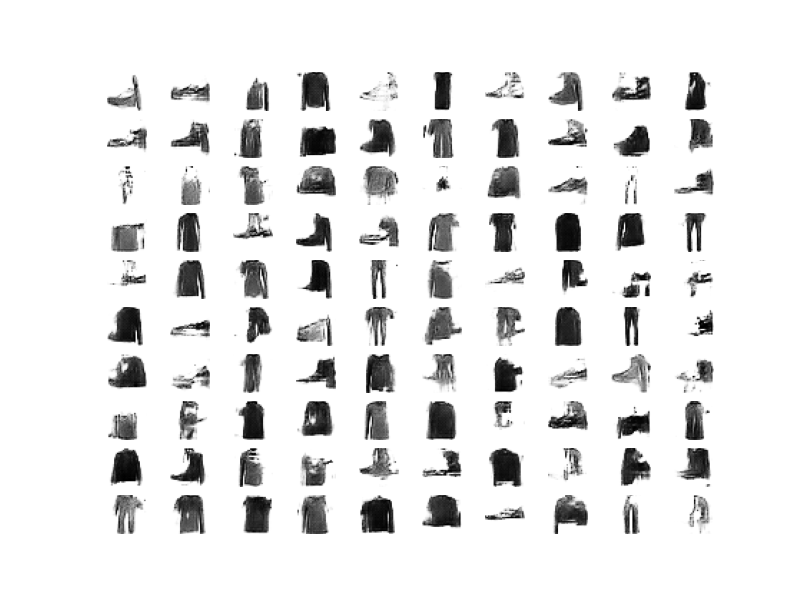

In [37]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
        pyplot.show()

#load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)

# cDCGAN

https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/